<a href="https://colab.research.google.com/github/BennettHilck12/DraftEdge/blob/main/DraftEdgeV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 5450 Final Project: DraftEdge

##### Bennett Hilck, Ethan Xia, Mohammed Soufan


# Part 1: Introduction



For our final project, we sought to better understand how NBA teams can draft players more effectively by predicting which NCAA D1 prospects are most likely to outperform expectations at the professional level. To pursue this goal, we compiled and analyzed several datasets containing college performance statistics, NBA Combine measurements and performance statistics, and eventual NBA outcomes.


By aggregrating and merging these data sources, we aim to identify advanced or undervalued metrics that may be overlook in traditional scouting evaluations. This approach alows us to quantitatvely asses why certain highly drafted players become "busts," while others selected later dramatically exceed their draft position.


Given the high variance and high cost associated with drafting, our project highlights non-obvious predictors that could help inform more data-driven decision-making and potentially reshape how teams and scouts approach future NBA drafts.


We hope that you find our project impactful!

# Part 2: Data Loading & Preprocessing


First, we must import all relevant libraries for our project. We will use all supplemental libraries throughout our project.

In [1]:
# Imports + Installs
!pip install category_encoders
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt
import folium
import numpy as np
import category_encoders as ce
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
import copy
from xgboost import XGBRegressor
from folium.plugins import HeatMap
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn import datasets, linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from torch.utils import data as data_utils
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.4 MB/s eta 0:00:00


## 2.1 Data Mounting + Storage

Because our datasets are quite large, often containing thousands of player seasons, detailed college statistics, and multiple years of NBA Combine measurements—we decided to upload them to Google Drive rather than store them locally. This allows us to efficiently access and manage the data from within our notebook environment without running into storage limitations or upload constraints. Hosting the data on Google Drive also ensures easier collaboration, as all team members can work from the same centralized, version-consistent files.

In [2]:
# Data Loading via Google Docs
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

folder_path = '/content/drive/MyDrive/final_project_datasets/'
files = os.listdir(folder_path)
print(files)

['team_details.csv', 'draft_combine_stats.csv', 'team.csv', 'game_info.csv', 'game_summary.csv', 'inactive_players.csv', 'player.csv', 'team_info_common.csv', 'draft_history.csv', 'team_history.csv', 'nbaPlayerData.xlsx', 'officials.csv', 'line_score.csv', 'game.csv', 'common_player_info.csv', 'draft_combine_stats.xlsx', 'other_stats.csv', 'nba_draft_2000_2025_clean.csv', 'nba_clean_df.xlsx', 'nba_player_stats_2000_2025.xlsx', 'nba_advanced_stats_2000_2025.xlsx', 'nba_draft_2000_2025.xlsx', 'college_data.xlsx']


## 2.2 Loading and Preprocessing NBA Combine Data

We wanted to add a disclaimer that most of our data was scraped from multiple websites, such as barttorvik.com and basketball-reference.com. We scraped an HTML table and used a Chromium headless browser to continually load more of the table.

First, let's load in our data from the NBA combine.

In [4]:
file_path = '/content/drive/MyDrive/final_project_datasets/draft_combine_stats.csv'
combine_df = pd.read_csv(file_path)
display(combine_df.head(10))

,season,player_id,first_name,last_name,player_name,position,height_wo_shoes,height_wo_shoes_ft_in,height_w_shoes,height_w_shoes_ft_in,...,spot_nba_break_right,spot_nba_corner_right,off_drib_fifteen_break_left,off_drib_fifteen_top_key,off_drib_fifteen_break_right,off_drib_college_break_left,off_drib_college_top_key,off_drib_college_break_right,on_move_fifteen,on_move_college
0,2001,12033,Adam,Allenspach,Adam Allenspach,C,83.50,6' 11.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,2240,Gilbert,Arenas,Gilbert Arenas,SG,74.25,6' 2.25'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001,2220,Brandon,Armstrong,Brandon Armstrong,SG,75.50,6' 3.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001,2203,Shane,Battier,Shane Battier,SF-PF,80.25,6' 8.25'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001,12034,Cookie,Belcher,Cookie Belcher,SG-PG,75.00,6' 3'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2001,2294,Charlie,Bell,Charlie Bell,PG,74.50,6' 2.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2001,2257,Ruben,Boumtje-Boumtje,Ruben Boumtje-Boumtje,C,83.50,6' 11.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2001,12035,Calvin,Bowman,Calvin Bowman,PF,80.75,6' 8.75'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2001,2214,Michael,Bradley,Michael Bradley,PF,81.50,6' 9.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2001,2249,Jamison,Brewer,Jamison Brewer,PG,74.50,6' 2.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
combine_df.dtypes

,0
season,int64
player_id,int64
first_name,object
last_name,object
player_name,object
position,object
height_wo_shoes,float64
height_wo_shoes_ft_in,object
height_w_shoes,float64
height_w_shoes_ft_in,object


In [6]:
combine_df.describe()

,season,player_id,height_wo_shoes,height_w_shoes,weight,wingspan,standing_reach,body_fat_pct,hand_length,hand_width,standing_vertical_leap,max_vertical_leap,lane_agility_time,modified_lane_agility_time,three_quarter_sprint,bench_press
count,1202.000000,1.202000e+03,1153.000000,1008.000000,1152.000000,1153.000000,1152.000000,1003.000000,719.000000,719.000000,1017.000000,1017.000000,1008.000000,411.000000,1012.000000,808.000000
mean,2012.536606,2.350133e+06,77.570902,78.796577,214.902604,82.478187,103.593663,7.352313,8.720793,9.448887,29.240167,34.637168,11.384444,3.079221,3.282213,10.155941
std,6.561620,5.660210e+07,3.334605,3.322625,25.718878,3.986623,4.880218,2.748712,0.481028,0.717066,3.054645,3.648106,0.584896,0.229143,0.131850,5.389231
min,2001.000000,-1.000000e+00,67.750000,69.000000,154.400000,70.000000,89.500000,2.600000,7.500000,7.000000,20.500000,25.000000,9.650000,2.220000,2.910000,0.000000
25%,2007.000000,1.011455e+05,75.250000,76.500000,195.950000,80.000000,100.000000,5.400000,8.500000,9.000000,27.000000,32.000000,10.970000,2.970000,3.190000,6.000000
50%,2012.000000,2.031470e+05,77.750000,79.000000,212.900000,82.750000,104.000000,6.700000,8.750000,9.500000,29.000000,34.500000,11.320000,3.100000,3.270000,10.000000
75%,2018.000000,1.629014e+06,80.000000,81.250000,233.000000,85.250000,107.000000,8.600000,9.000000,10.000000,31.500000,37.000000,11.720000,3.230000,3.360000,14.000000
max,2023.000000,1.962937e+09,89.250000,91.000000,314.000000,98.250000,122.500000,21.000000,10.500000,12.000000,39.500000,45.500000,13.440000,3.760000,3.810000,26.000000


However, we know that the NBA combine is invite only, and many players who get drafted do not go to the combine. For that, we can look towards the entirety of NCAA D1 Men's Basketball data.

## 2.3 Loading and Preprocessing NCAA Data

And let's also take a look at our NCAA D1 player stats, which we scraped from barttorvik.com, a live NCAA D1 player stats tracker by season.

In [7]:
file_path = '/content/drive/MyDrive/final_project_datasets/college_data.xlsx'
ncaa_df = pd.read_excel(file_path)
display(ncaa_df.head(10))

,Rk,Player,Class,Team,Conf,Min%,PRPG!,BPM,ORtg,USG%,...,DRB%,AST%,TOV%,BLK%,STL%,FTR%,2P%,3P/100,3P%,Year
0,1,Bennett Stirtz,Jr,Drake,MVC,98.8,6.4,10.0,126.4,26.1,...,14.0,34.0,13.1,1.0,3.3,38.6,0.545,7.7,0.396,2025
1,2,Bruce Thornton,Jr,Ohio St.,B10,88.4,6.3,8.7,130.0,22.0,...,10.0,25.1,10.8,0.4,1.8,41.8,0.547,7.0,0.424,2025
2,3,Ryan Kalkbrenner,Sr,Creighton,BE,83.1,6.1,11.1,129.2,22.3,...,18.4,10.0,11.2,7.3,0.9,38.6,0.706,3.0,0.344,2025
3,4,Eric Dixon,Sr,Villanova,BE,84.3,6.1,7.3,116.7,32.9,...,12.6,13.1,11.8,1.1,1.5,35.8,0.483,13.1,0.407,2025
4,5,Cooper Flagg,Fr,Duke,ACC,72.8,6.0,14.9,123.0,30.8,...,21.2,26.8,13.5,4.9,2.8,42.9,0.517,7.2,0.385,2025
5,6,Trey Kaufman-Renn,Jr,Purdue,B10,76.9,5.7,7.9,118.1,31.1,...,15.4,16.8,13.9,1.2,1.4,42.8,0.597,0.4,0.429,2025
6,7,Johni Broome,Sr,Auburn,SEC,71.4,5.7,12.9,118.5,30.6,...,26.0,19.5,9.9,7.5,1.8,39.0,0.559,4.8,0.278,2025
7,8,Braden Smith,Jr,Purdue,B10,92.6,5.7,9.4,116.1,26.6,...,13.5,44.1,18.6,0.7,3.5,20.3,0.469,9.9,0.381,2025
8,9,Kam Jones,Sr,Marquette,BE,83.9,5.7,9.3,118.1,29.2,...,13.6,38.1,11.1,0.9,2.4,16.0,0.586,10.6,0.311,2025
9,10,Tyson Degenhart,Sr,Boise St.,MWC,84.5,5.6,7.6,126.8,23.8,...,15.3,10.3,10.7,0.9,1.1,50.5,0.618,7.6,0.349,2025


In [8]:
ncaa_df.dtypes

,0
Rk,int64
Player,object
Class,object
Team,object
Conf,object
Min%,float64
PRPG!,float64
BPM,float64
ORtg,float64
USG%,float64


In [9]:
ncaa_df.describe()

,Rk,Min%,PRPG!,BPM,ORtg,USG%,eFG%,TS%,ORB%,DRB%,AST%,TOV%,BLK%,STL%,FTR%,2P%,3P/100,3P%,Year
count,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000
mean,1088.863973,63.886001,1.601908,0.508939,103.134344,20.155992,50.251591,53.593196,5.069479,13.179956,13.647076,18.396751,1.797867,1.892037,35.759151,0.484399,5.994695,0.294807,2016.615569
std,629.257082,13.680132,1.343539,3.643385,10.595077,4.613991,6.271648,5.656281,3.587501,4.846323,7.603259,5.055464,2.141272,0.801671,15.741384,0.077856,4.120459,0.137440,5.194556
min,1.000000,40.000000,-2.700000,-13.300000,55.400000,6.100000,18.300000,20.300000,0.000000,2.100000,0.000000,2.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2008.000000
25%,544.000000,52.400000,0.700000,-2.000000,96.300000,16.800000,46.100000,49.900000,2.100000,9.500000,7.900000,14.900000,0.400000,1.300000,24.500000,0.433000,2.500000,0.262000,2012.000000
50%,1088.000000,63.900000,1.500000,0.400000,103.300000,19.900000,50.000000,53.600000,4.000000,12.500000,12.000000,17.900000,1.000000,1.800000,33.600000,0.483000,6.000000,0.330000,2017.000000
75%,1632.000000,74.975000,2.400000,2.900000,110.200000,23.200000,54.300000,57.300000,7.500000,16.300000,18.000000,21.300000,2.400000,2.300000,44.900000,0.535000,9.100000,0.374000,2021.000000
max,2308.000000,98.800000,7.900000,18.700000,161.400000,38.500000,88.300000,80.400000,23.700000,39.200000,52.600000,54.100000,18.800000,7.600000,147.900000,1.000000,23.100000,1.000000,2025.000000


## 2.4 Loading and Preprocessing NBA Draft Data

Let's also take a look at our NBA Draft data, which we scraped from basketball-reference.com, a live NBA tracker

In [12]:
file_path = '/content/drive/MyDrive/final_project_datasets/nba_draft_2000_2025_clean.csv'
draft_df = pd.read_csv(file_path)
display(draft_df.head(10))

,Rk,Pk,Tm,Player,College,Yrs,G,MP,PTS,TRB,...,FT%,MP.1,PTS.1,TRB.1,AST.1,WS,WS/48,BPM,VORP,Year
0,1.0,1.0,NJN,Kenyon Martin,Cincinnati,15,757,23134,9325,5159,...,0.629,30.6,12.3,6.8,1.9,48,0.1,0.1,12.1,2000
1,2.0,2.0,VAN,Stromile Swift,LSU,9,547,10804,4582,2535,...,0.699,19.8,8.4,4.6,0.5,21.3,0.095,-1.6,1.1,2000
2,3.0,3.0,LAC,Darius Miles,NaN,7,446,11730,4507,2190,...,0.59,26.3,10.1,4.9,1.9,9.5,0.039,-1,3,2000
3,4.0,4.0,CHI,Marcus Fizer,Iowa State,6,289,6032,2782,1340,...,0.691,20.9,9.6,4.6,1.2,2.7,0.022,-3.7,-2.6,2000
4,5.0,5.0,ORL,Mike Miller,Florida,17,1032,27812,10973,4376,...,0.769,26.9,10.6,4.2,2.6,60.7,0.105,0.8,19.8,2000
5,6.0,6.0,ATL,DerMarr Johnson,Cincinnati,7,344,5930,2121,769,...,0.789,17.2,6.2,2.2,0.9,6.4,0.052,-1.6,0.6,2000
6,7.0,7.0,CHI,Chris Mihm,Texas,8,436,8758,3262,2302,...,0.704,20.1,7.5,5.3,0.5,13.3,0.073,-3.9,-4.3,2000
7,8.0,8.0,CLE,Jamal Crawford,Michigan,20,1327,38994,19419,2948,...,0.862,29.4,14.6,2.2,3.4,60.7,0.075,-0.1,18.4,2000
8,9.0,9.0,HOU,Joel Przybilla,Minnesota,13,592,11733,2293,3665,...,0.557,19.8,3.9,6.2,0.4,23,0.094,-1.7,0.8,2000
9,10.0,10.0,ORL,Keyon Dooling,Missouri,13,728,14134,5067,964,...,0.799,19.4,7,1.3,2.2,18.5,0.063,-2,-0.2,2000


In [13]:
draft_df.dtypes

,0
Rk,float64
Pk,float64
Tm,object
Player,object
College,object
Yrs,object
G,object
MP,object
PTS,object
TRB,object


In [14]:
draft_df.describe()

,Rk,Pk,Year
count,1545.000000,1545.000000,1578.000000
mean,30.277023,30.257605,2012.555767
std,17.217246,17.200612,7.479822
min,1.000000,1.000000,2000.000000
25%,15.000000,15.000000,2006.000000
50%,30.000000,30.000000,2013.000000
75%,45.000000,45.000000,2019.000000
max,60.000000,60.000000,2025.000000


## 2.5 Loading and Preprocessing NBA Player Data

We will also load in our NBA player data, which we scraped from Basketball-reference.com. We will merge these two dataframes together later in part 3.

In [15]:
file_path = '/content/drive/MyDrive/final_project_datasets/nba_player_stats_2000_2025.xlsx'
nba_df = pd.read_excel(file_path)
display(nba_df.head(10))

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Year
0,1.0,Shaquille O'Neal,27.0,LAL,C,79.0,79.0,40.0,12.1,21.1,...,9.4,13.6,3.8,0.5,3.0,2.8,3.2,29.7,"MVP-1,DPOY-2,AS,NBA1,DEF2",2000
1,2.0,Allen Iverson,24.0,PHI,SG,70.0,70.0,40.8,10.4,24.8,...,2.8,3.8,4.7,2.1,0.1,3.3,2.3,28.4,"MVP-7,AS,NBA2",2000
2,3.0,Grant Hill,27.0,DET,SF,74.0,74.0,37.5,9.4,19.2,...,5.3,6.6,5.2,1.4,0.6,3.2,2.6,25.8,"MVP-8,AS,NBA2",2000
3,4.0,Vince Carter,23.0,TOR,SF,82.0,82.0,38.1,9.6,20.7,...,4.0,5.8,3.9,1.3,1.1,2.2,3.2,25.7,"MVP-10,AS,NBA3",2000
4,5.0,Karl Malone,36.0,UTA,PF,82.0,82.0,35.9,9.2,18.0,...,7.4,9.5,3.7,1.0,0.9,2.8,2.8,25.5,"MVP-4,AS,NBA2",2000
5,6.0,Chris Webber,26.0,SAC,PF,75.0,75.0,38.4,10.0,20.6,...,8.0,10.5,4.6,1.6,1.7,2.9,3.5,24.5,"MVP-9,AS,NBA3",2000
6,7.0,Gary Payton,31.0,SEA,PG,82.0,82.0,41.8,9.1,20.3,...,5.2,6.5,8.9,1.9,0.2,2.7,2.2,24.2,"MVP-6,DPOY-5,AS,NBA1,DEF1",2000
7,8.0,Jerry Stackhouse,25.0,DET,SG,82.0,82.0,38.4,7.5,17.6,...,2.4,3.8,4.5,1.3,0.4,3.8,2.3,23.6,AS,2000
8,9.0,Tim Duncan,23.0,SAS,PF,74.0,74.0,38.9,8.5,17.3,...,8.9,12.4,3.2,0.9,2.2,3.3,2.8,23.2,"MVP-5,AS,NBA1,DEF1",2000
9,10.0,Kevin Garnett,23.0,MIN,PF,81.0,81.0,40.0,9.4,18.8,...,9.0,11.8,5.0,1.5,1.6,3.3,2.5,22.9,"MVP-2,DPOY-7,AS,NBA1,DEF1",2000


In [16]:
nba_df.dtypes

,0
Rk,float64
Player,object
Age,float64
Team,object
Pos,object
G,float64
GS,float64
MP,float64
FG,float64
FGA,float64


In [17]:
nba_df.describe()

,Rk,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
count,10424.000000,10424.000000,10424.000000,10424.000000,10424.000000,10424.000000,10424.000000,10423.000000,10424.000000,10424.000000,...,10424.000000,10424.000000,10424.000000,10424.000000,10424.000000,10424.000000,10424.000000,10424.000000,10424.000000,10426.000000
mean,201.577609,26.586051,57.226976,29.603223,22.700192,3.585514,7.901180,0.450928,0.775902,2.180861,...,1.033548,2.975758,4.007185,2.125863,0.716193,0.458183,1.305631,1.974760,9.632118,2012.302417
std,116.814352,4.277176,21.857762,28.954733,8.750848,2.129710,4.491771,0.072777,0.785963,2.062742,...,0.821253,1.772241,2.439897,1.857360,0.418144,0.477290,0.778820,0.713242,5.903529,7.528755
min,1.000000,18.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000
25%,101.000000,23.000000,44.000000,3.000000,15.800000,2.000000,4.400000,0.410000,0.000000,0.200000,...,0.400000,1.700000,2.200000,0.800000,0.400000,0.100000,0.700000,1.500000,5.200000,2006.000000
50%,201.000000,26.000000,63.000000,18.000000,22.400000,3.100000,6.800000,0.444000,0.600000,1.800000,...,0.800000,2.600000,3.400000,1.500000,0.600000,0.300000,1.100000,2.000000,8.200000,2012.000000
75%,301.000000,29.000000,75.000000,58.000000,29.900000,4.800000,10.500000,0.485000,1.300000,3.500000,...,1.400000,3.800000,5.200000,2.800000,0.900000,0.600000,1.700000,2.500000,12.800000,2019.000000
max,444.000000,44.000000,85.000000,83.000000,43.700000,12.200000,27.800000,1.000000,5.300000,13.200000,...,5.500000,11.500000,16.300000,11.700000,3.000000,3.800000,5.700000,6.000000,36.100000,2025.000000


## 2.6 Loading and Preprocessing Advanced Statistics

Finally, we will load in our data of advanced statistics, which we also scraped from basketball-reference.com. We hope that these advanced statistics can include specific statistics that will make underdog or outperforming players stand out.

In [18]:
file_path = '/content/drive/MyDrive/final_project_datasets/nba_advanced_stats_2000_2025.xlsx'
advanced_df = pd.read_excel(file_path)
display(advanced_df.head(10))

,Rk,Player,Age,Team,Pos,G,GS,MP,PER,TS%,...,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards,Year
0,1.0,Michael Finley,26.0,DAL,SF,82.0,82.0,3464.0,19.2,0.522,...,6.4,1.9,8.3,0.114,3.0,-0.9,2.1,3.6,"MVP-13,AS",2000
1,2.0,Gary Payton,31.0,SEA,PG,82.0,82.0,3425.0,23.6,0.535,...,10.5,3.5,13.9,0.195,5.8,0.7,6.4,7.3,"MVP-6,DPOY-5,AS,NBA1,DEF1",2000
2,3.0,Latrell Sprewell,29.0,NYK,SF,82.0,82.0,3276.0,15.7,0.515,...,2.5,4.1,6.6,0.097,0.5,0.5,1.0,2.5,NaN,2000
3,4.0,Kevin Garnett,23.0,MIN,PF,81.0,81.0,3243.0,23.6,0.545,...,6.1,5.6,11.6,0.172,4.6,1.7,6.3,6.8,"MVP-2,DPOY-7,AS,NBA1,DEF1",2000
4,5.0,Shareef Abdur-Rahim,23.0,VAN,SF,82.0,82.0,3223.0,20.2,0.547,...,6.2,2.6,8.8,0.132,2.6,-0.4,2.2,3.4,NaN,2000
5,6.0,Allan Houston,28.0,NYK,SG,82.0,82.0,3169.0,16.5,0.569,...,5.5,3.1,8.6,0.130,1.8,-0.2,1.7,2.9,AS,2000
6,7.0,Shaquille O'Neal,27.0,LAL,C,79.0,79.0,3163.0,30.6,0.578,...,11.7,7.0,18.6,0.283,7.3,2.0,9.3,9.0,"MVP-1,DPOY-2,AS,NBA1,DEF2",2000
7,8.0,Mike Bibby,21.0,VAN,PG,82.0,82.0,3155.0,16.7,0.521,...,4.5,1.1,5.6,0.086,1.9,-1.3,0.6,2.1,NaN,2000
8,9.0,Jerry Stackhouse,25.0,DET,SG,82.0,82.0,3148.0,18.9,0.545,...,5.7,1.6,7.3,0.111,2.8,-1.7,1.0,2.4,AS,2000
9,10.0,Anthony Mason,33.0,CHH,SF,82.0,81.0,3133.0,14.4,0.560,...,4.9,3.9,8.9,0.136,0.1,0.7,0.8,2.2,DPOY-8,2000


In [19]:
advanced_df.dtypes

,0
Rk,float64
Player,object
Age,float64
Team,object
Pos,object
G,float64
GS,float64
MP,float64
PER,float64
TS%,float64


In [20]:
advanced_df.describe()

,Rk,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Year
count,10419.000000,10419.000000,10419.000000,10419.000000,10419.000000,10419.000000,10418.000000,10418.000000,10418.000000,10421.000000,...,10421.000000,10419.000000,10419.000000,10419.000000,10419.000000,10419.000000,10419.000000,10419.000000,10419.000000,10421.000000
mean,201.465016,26.653902,59.215664,29.828103,1423.143584,13.669200,0.531421,0.263966,0.283013,5.455676,...,18.845226,1.598244,1.448949,3.047548,0.087133,-0.869488,-0.048565,-0.918620,0.743776,2012.296133
std,116.736548,4.321145,19.202012,28.815299,801.373275,4.658049,0.065067,0.215277,0.149887,3.959029,...,5.109760,2.103309,1.149054,2.930718,0.064206,2.676213,1.229130,3.088168,1.409362,7.520083
min,1.000000,18.000000,1.000000,0.000000,1.000000,-28.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-3.300000,-0.600000,-2.100000,-0.859000,-25.200000,-19.100000,-44.200000,-2.600000,2000.000000
25%,101.000000,23.000000,47.000000,3.000000,743.000000,10.700000,0.498000,0.032000,0.181000,2.300000,...,15.300000,0.100000,0.600000,0.800000,0.051000,-2.500000,-0.900000,-2.700000,-0.100000,2006.000000
50%,201.000000,26.000000,64.000000,19.000000,1383.000000,13.300000,0.535000,0.262500,0.256000,4.100000,...,18.300000,1.000000,1.200000,2.300000,0.088000,-0.900000,-0.100000,-1.000000,0.300000,2012.000000
75%,301.000000,30.000000,75.000000,58.000000,2049.000000,16.300000,0.570000,0.425000,0.354000,8.200000,...,22.000000,2.500000,2.000000,4.500000,0.125000,0.700000,0.700000,0.800000,1.200000,2019.000000
max,444.000000,44.000000,85.000000,83.000000,3485.000000,34.100000,0.868000,1.000000,2.000000,42.300000,...,44.400000,14.800000,9.100000,20.300000,0.420000,10.300000,10.100000,14.100000,11.800000,2025.000000


# Part 3: Wrangling

### 3.1 Data Filtering

We can see that although ncaa_df ranges from 2008 - 2025, combine_df only ranges from 2001 - 2023. This indicates that we will have to clean and format our dataframes to only include relevant years for processing.

### 3.1.1 Normalizing Column Names

In [21]:
for df in [combine_df, ncaa_df, draft_df, nba_df, advanced_df]:
    df.columns = df.columns.str.lower()


### 3.1.2 Normalizing Column Datatypes

Next, we want to normalize our columns and dtypes across dataframes so that we are able to merge correctly.

## 3.3 Data Merge

Finally, we want to merge our datasets so we can perform meaningful EDA analysis

### 3.3.1 NBA Data Merge

merge the nba basic stats with advanced stats to cover the advanced metrics that might give us more of an insight into how to draft players more efficiently. First we have to ensure they cover the same years (2008-2023) so we have to clean both dfs a by making sure 2023 is the cutoff year. We also made sure to sort the stats to make sure the merged data frame is easily understood.

In [23]:
import pandas as pd
from IPython.display import display

# --- Using your already-loaded dataframes (lowercased) ---
clean = nba_df
adv   = advanced_df

# Clean advanced stats: dedupe and drop redundant columns
adv = adv.drop_duplicates(subset=["player", "team", "year"])
cols_to_drop = ["rk", "age", "g", "gs", "mp", "pos", "awards"]
adv = adv.drop(columns=cols_to_drop, errors="ignore")

# Merge base + advanced on player / team / year
nba_adv_df = clean.merge(
    adv,
    on=["player", "team", "year"],
    how="left",
    suffixes=("", "_adv")
)

# Detect scoring column for sorting
possible_ppg_cols = ["ppg", "pts", "pts_per_game"]
ppg_col = None
for c in possible_ppg_cols:
    if c in nba_adv_df.columns:
        ppg_col = c
        break
if ppg_col is None:
    raise ValueError("Could not find a PPG/PTS column to sort by.")

# Sort rows by year then scoring (desc)
nba_adv_df = nba_adv_df.sort_values(
    by=["year", ppg_col],
    ascending=[True, False]
).reset_index(drop=True)

# Scoring rank (within each year)
rank_series = nba_adv_df.groupby("year")[ppg_col].rank(method="dense", ascending=False)
nba_adv_df["scoring_rank"] = rank_series.astype("Int64")

# ---------- Column ordering ----------

cols = list(nba_adv_df.columns)

# Identify year + award columns
year_col = "year" if "year" in cols else None
award_cols = [c for c in cols if "award" in c.lower()]

# ID/meta columns
id_candidates = ["scoring_rank", "player", "pos", "age", "team", "tm"]
id_cols = [c for c in id_candidates if c in cols]

# Priority stat groups
points_cols  = [c for c in ["pts"] if c in cols]
assist_cols  = [c for c in ["ast", "ast%"] if c in cols]
rebound_cols = [c for c in ["trb", "trb%", "drb", "drb%", "orb", "orb%"] if c in cols]
block_cols   = [c for c in ["blk", "blk%"] if c in cols]
steal_cols   = [c for c in ["stl", "stl%"] if c in cols]
turnover_cols = [c for c in ["tov", "tov%"] if c in cols]

# Shooting groups
fg_cols    = [c for c in ["fg", "fga", "fg%", "efg%"] if c in cols]
three_cols = [c for c in ["3p", "3pa", "3p%", "3par"] if c in cols]
two_cols   = [c for c in ["2p", "2pa", "2p%"] if c in cols]
ft_cols    = [c for c in ["ft", "fta", "ft%", "ftr"] if c in cols]

# Core advanced metrics
adv_core_cols = [
    c for c in [
        "per", "ts%", "usg%", "ows", "dws", "ws", "ws/48",
        "obpm", "dbpm", "bpm", "vorp"
    ] if c in cols
]

# Ordered stat sequence
ordered_stats = (
    points_cols +
    assist_cols +
    rebound_cols +
    block_cols +
    steal_cols +
    turnover_cols +
    fg_cols +
    three_cols +
    two_cols +
    ft_cols +
    adv_core_cols
)

# Track used columns
used = set(id_cols + ordered_stats + award_cols + ([year_col] if year_col else []))

# Remaining columns in natural order
other_cols = [c for c in cols if c not in used]

# Build final order
new_order = id_cols + ordered_stats + other_cols
if award_cols:
    new_order += award_cols
if year_col:
    new_order += [year_col]

nba_adv_df = nba_adv_df[new_order]

display(nba_adv_df.head())


,scoring_rank,player,pos,age,team,pts,ast,ast%,trb,trb%,...,dbpm,bpm,vorp,rk,g,gs,mp,pf,awards,year
0,1,Shaquille O'Neal,C,27.0,LAL,29.7,3.8,19.3,13.6,18.3,...,2.0,9.3,9.0,1.0,79.0,79.0,40.0,3.2,"MVP-1,DPOY-2,AS,NBA1,DEF2",2000
1,2,Allen Iverson,SG,24.0,PHI,28.4,4.7,23.0,3.8,5.2,...,-0.2,3.2,3.8,2.0,70.0,70.0,40.8,2.3,"MVP-7,AS,NBA2",2000
2,3,Grant Hill,SF,27.0,DET,25.8,5.2,26.8,6.6,10.2,...,0.1,5.4,5.2,3.0,74.0,74.0,37.5,2.6,"MVP-8,AS,NBA2",2000
3,4,Vince Carter,SF,23.0,TOR,25.7,3.9,20.5,5.8,8.5,...,-0.1,5.5,5.9,4.0,82.0,82.0,38.1,3.2,"MVP-10,AS,NBA3",2000
4,5,Karl Malone,PF,36.0,UTA,25.5,3.7,20.9,9.5,16.1,...,1.1,7.5,7.1,5.0,82.0,82.0,35.9,2.8,"MVP-4,AS,NBA2",2000


### 3.3.2 NBA Draft and Combine Merge

merge combine_df and draft_df

In [26]:
# Rename 'player_name' to 'player' in combine_df for consistency
combine_df = combine_df.rename(columns={'player_name': 'player'})

# Rename 'season' to 'year' in combine_df for consistency with draft_df
combine_df = combine_df.rename(columns={'season': 'year'})

# Clean whitespace
combine_df['player'] = combine_df['player'].str.strip()
draft_df['player'] = draft_df['player'].str.strip()

# Merge on player + year
combine_draft_df = draft_df.merge(
    combine_df,
    on=['player', 'year'],
    how='left'
)

print(combine_draft_df.columns)

Index(['rk', 'pk', 'tm', 'player', 'college', 'yrs', 'g', 'mp', 'pts', 'trb',
       'ast', 'fg%', '3p%', 'ft%', 'mp.1', 'pts.1', 'trb.1', 'ast.1', 'ws',
       'ws/48', 'bpm', 'vorp', 'year', 'player_id', 'first_name', 'last_name',
       'position', 'height_wo_shoes', 'height_wo_shoes_ft_in',
       'height_w_shoes', 'height_w_shoes_ft_in', 'weight', 'wingspan',
       'wingspan_ft_in', 'standing_reach', 'standing_reach_ft_in',
       'body_fat_pct', 'hand_length', 'hand_width', 'standing_vertical_leap',
       'max_vertical_leap', 'lane_agility_time', 'modified_lane_agility_time',
       'three_quarter_sprint', 'bench_press', 'spot_fifteen_corner_left',
       'spot_fifteen_break_left', 'spot_fifteen_top_key',
       'spot_fifteen_break_right', 'spot_fifteen_corner_right',
       'spot_college_corner_left', 'spot_college_break_left',
       'spot_college_top_key', 'spot_college_break_right',
       'spot_college_corner_right', 'spot_nba_corner_left',
       'spot_nba_break_left', 's

# Part 4: Exploratory Data Analysis

After generating a summary of our data and examining the overall data distribution, we can begin to explore insights and relationships between features, which will ultimately help us determine a better drafting procedure. In this section, we explore how NCAA performance statistics relate to the physical and athletic measurements collected at the NBA Combine. By comparing metrics such as wingspan, vertical leap, sprint time, and shooting or efficiency statistics, we aim to uncover relationships that may help explain how a player’s physical tools translate into on-court impact. These comparisons are important because they give us insight into which measurable physical attributes are associated with effective college performance and ultimately, which features may be most predictive when constructing a draft projection model. The goal is not only to visualize trends, but also to identify feature pairs where physical measurements meaningfully correlate with skill, efficiency, or overall impact.

In [38]:
print("NCAA rows:", ncaa_df.shape)
print("NBA merged rows:", nba_adv_df.shape)
print("Combine+Draft merged rows:", combine_draft_df.shape)

# show missingness top
def missing_table(df):
    miss = df.isnull().mean().sort_values(ascending=False)
    return pd.DataFrame({'missing_pct': miss[miss>0]})
print("NCAA missingness (top):")
display(missing_table(ncaa_df).head(30))

NCAA rows: (39154, 23)
NBA merged rows: (10426, 53)
Combine+Draft merged rows: (1578, 68)
NCAA missingness (top):


,missing_pct
class,0.000102


## 4.1 Draft Pick vs. NBA BPM

It's crucial to analyze the relationship between a player's Draft Pick and their long-term NBA Box Plus/Minus to assess the efficiency and accuracy of the NBA drafting process. Teams invest highly in early picks, expecting high BPM scores, so a weak correlation or finding late picks with high BPM indicates significant potential for teams to find under-valued talent or highlights when early picks fail to meet expectations.

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(draft_nba_df['pk'], draft_nba_df['bpm_y'], alpha=0.6, label='Players')
plt.axhline(draft_nba_df['bpm_y'].mean(), color='red', linestyle='--', label='League Avg BPM')
plt.xlabel("Draft Pick")
plt.ylabel("NBA BPM")
plt.title("Draft Pick vs NBA BPM")
plt.gca().invert_xaxis()  # lower draft pick = better
plt.legend()
plt.show()

For this sample, we can see that the player drafted later (45th pick) had a significantly higher NBA BPM than the player drafted earlier (43rd pick). This suggests that for these two players, the draft order was not a good predictor of their performance as measured by BPM

## 4.2 College WS/48 vs NBA Prospects

In [ ]:
# Convert ws/48 to numeric, coercing errors to NaN
draft_df['ws/48'] = pd.to_numeric(draft_df['ws/48'], errors='coerce')

plt.figure(figsize=(8,5))
plt.hist(draft_df['ws/48'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.axvline(draft_df['ws/48'].dropna().mean(), color='red', linestyle='--', label='Average WS/48')
plt.xlabel("College WS/48")
plt.ylabel("Number of Players")
plt.title("Distribution of College WS/48 for NBA Prospects")
plt.legend()
plt.show()


This histogram illustrates the distribution of College Win Shares per 48 minutes for a dataset of NBA prospects. This shows that the College Win Shares for NBA prospects is heavily concentrated around a positive, above-average value. This is expected, since NBA teams generally select players who have demonstrated a high level of efficiency and positive contribution. However, there are still a lot of players who are below 0, which are our underdogs which we will try to find.

## 4.3 Wingspan vs. Player Height

In [ ]:
mean_wingspan = combine_df['wingspan'].mean()

plt.figure(figsize=(8,5))
plt.scatter(combine_df['height_w_shoes'], combine_df['wingspan'], alpha=0.6, color='green')

plt.axhline(mean_wingspan,
            color='red',
            linestyle='--',
            label=f'Avg Wingspan: {mean_wingspan:.2f} inches')

plt.xlabel("Height (inches)")
plt.ylabel("Wingspan (inches)")
plt.title("Player Height vs Wingspan at NBA Combine")
plt.legend()
plt.show()

The plot visually confirms that height is an excellent predictor of wingspan among NBA prospects. Crucially for basketball, the data highlights that most prospects selected for the NBA Combine possess a wingspan that is disproportionately long compared to their height, suggesting the NBA prioritizes this physical advantage.

## 4.4 NBA vs. Draft EDA

Take players in nba_total_df and match to draft_df. compare player's NBA advanced stats to their draft number and league-wide average advanced stats. Identify specific players with above-average advanced metrics and see how their draft position compares

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(combine_df['wingspan'], ncaa_df['BPM'])
plt.xlabel("Wingspan (inches)")
plt.ylabel("BPM")
plt.title("Wingspan vs College BPM")
plt.show()


Explanation

Also compare how draft position correlates with NBA outcomes such as awards, longterm advanced stats (PER, BPM, WS). Identify common advanced metrics that successful players share

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(combine_df['wingspan'], ncaa_df['BPM'])
plt.xlabel("Wingspan (inches)")
plt.ylabel("BPM")
plt.title("Wingspan vs College BPM")
plt.show()


Explanation

## 4.5 NCAA vs. Draft EDA

Compare draft pick with college performance by merging draft_df and ncaa_df. Identify which college stats translate best into draft position

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(combine_df['max_vertical_leap'].dropna(), bins=20)
plt.xlabel("Max Vertical Leap (inches)")
plt.ylabel("Count")
plt.title("Distribution of Max Vertical Leap")
plt.show()


Explanation

## 4.6 College vs. Draft vs. NBA

Average stats by draft pick and compare these averages to average college stats by pick and average nba stats by pick.

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(ncaa_df['ts%'], combine_df['three_quarter_sprint'])
plt.xlabel("NCAA TS%")
plt.ylabel("Three-Quarter Sprint (sec)")
plt.title("TS% vs Sprint Time")
plt.show()


**Min Distribution in College**

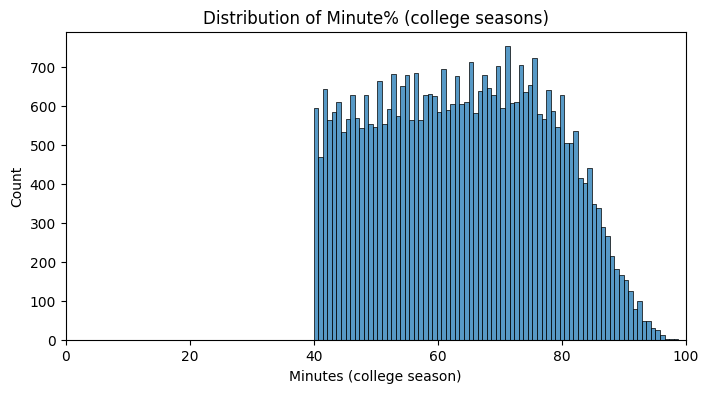

In [28]:
plt.figure(figsize=(8,4))
sns.histplot(ncaa_df.loc[ncaa_df['min%']>0, 'min%'], bins=80, kde=False)
plt.xlabel("Minutes (college season)")
plt.title("Distribution of Minute% (college seasons)")
plt.xlim(0, 100)
plt.show()

Guys under 16 Minutes are already filtered out

**PRPG! by Conference**

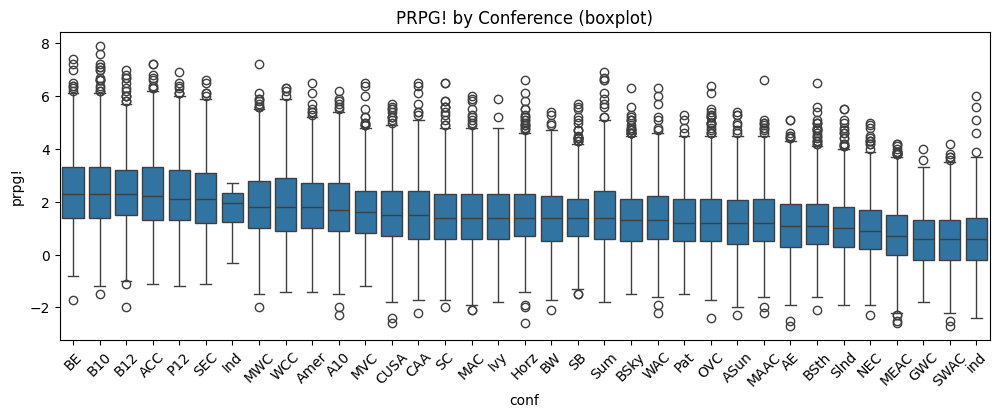

In [37]:
if "conf" in ncaa_df.columns and "prpg!" in ncaa_df.columns:
    plt.figure(figsize=(12,4))
    order = (ncaa_df.groupby("conf")['prpg!'].median().sort_values(ascending=False).index)
    sns.boxplot(data=ncaa_df, x="conf", y="prpg!", order=order)
    plt.xticks(rotation=45)
    plt.title("PRPG! by Conference (boxplot)")
    plt.show()

### EDA for NBA Players with Awards

In [31]:
# Filter out rows where 'awards' is NaN or empty string
award_winners_df = nba_adv_df[nba_adv_df['awards'].notna() & (nba_adv_df['awards'] != '')].copy()

print(f"Number of entries with awards: {len(award_winners_df)}")
display(award_winners_df.head())


Number of entries with awards: 1535


,scoring_rank,player,pos,age,team,pts,ast,ast%,trb,trb%,...,dbpm,bpm,vorp,rk,g,gs,mp,pf,awards,year
0,1,Shaquille O'Neal,C,27.0,LAL,29.7,3.8,19.3,13.6,18.3,...,2.0,9.3,9.0,1.0,79.0,79.0,40.0,3.2,"MVP-1,DPOY-2,AS,NBA1,DEF2",2000
1,2,Allen Iverson,SG,24.0,PHI,28.4,4.7,23.0,3.8,5.2,...,-0.2,3.2,3.8,2.0,70.0,70.0,40.8,2.3,"MVP-7,AS,NBA2",2000
2,3,Grant Hill,SF,27.0,DET,25.8,5.2,26.8,6.6,10.2,...,0.1,5.4,5.2,3.0,74.0,74.0,37.5,2.6,"MVP-8,AS,NBA2",2000
3,4,Vince Carter,SF,23.0,TOR,25.7,3.9,20.5,5.8,8.5,...,-0.1,5.5,5.9,4.0,82.0,82.0,38.1,3.2,"MVP-10,AS,NBA3",2000
4,5,Karl Malone,PF,36.0,UTA,25.5,3.7,20.9,9.5,16.1,...,1.1,7.5,7.1,5.0,82.0,82.0,35.9,2.8,"MVP-4,AS,NBA2",2000


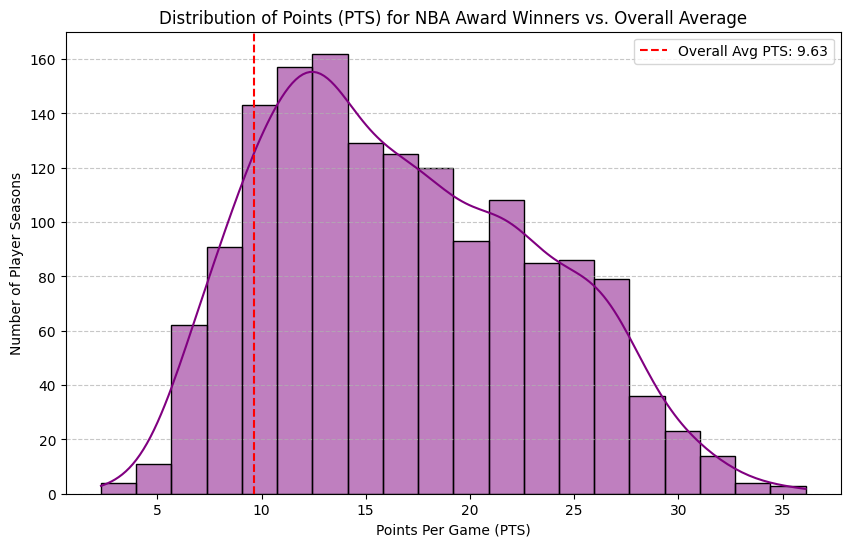

In [35]:
overall_avg_pts = nba_adv_df['pts'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(award_winners_df['pts'], bins=20, kde=True, color='purple')
plt.axvline(overall_avg_pts, color='red', linestyle='--', label=f'Overall Avg PTS: {overall_avg_pts:.2f}')
plt.title('Distribution of Points (PTS) for NBA Award Winners vs. Overall Average')
plt.xlabel('Points Per Game (PTS)')
plt.ylabel('Number of Player Seasons')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [33]:
# Display top 10 award-winning player seasons by BPM
print("\nTop 10 Award-Winning Player Seasons by BPM:")
display(award_winners_df.sort_values(by='bpm', ascending=False)[['player', 'year', 'awards', 'bpm', 'pts']].head(10))



Top 10 Award-Winning Player Seasons by BPM:


,player,year,awards,bpm,pts
8885,Nikola Jokic,2022,"MVP-1,AS,NBA1",13.7,27.1
10040,Nikola Jokic,2025,"MVP-2,CPOY-2,AS,NBA1",13.3,29.6
9665,Nikola Jokic,2024,"MVP-1,CPOY-4,AS,NBA1",13.2,26.4
3737,LeBron James,2009,"MVP-1,DPOY-2,AS,NBA1,DEF1",13.2,28.4
9284,Nikola Jokic,2023,"MVP-2,CPOY-13,AS,NBA2",13.0,24.5
8504,Nikola Jokic,2021,"MVP-1,AS,NBA1",12.1,26.4
6496,Stephen Curry,2016,"MVP-1,AS,NBA1",11.9,30.1
4121,LeBron James,2010,"MVP-1,DPOY-4,AS,NBA1,DEF1",11.8,29.7
5304,LeBron James,2013,"MVP-1,DPOY-2,AS,NBA1,DEF1",11.7,26.8
9654,Joel Embiid,2024,AS,11.6,34.7


## 4.7 Heatmap + Feature Correlation Matrix

We will apply a Heatmap + Feature Correlation Matrix to quickly identify strong corrleations in our data before heading into more advanced models.

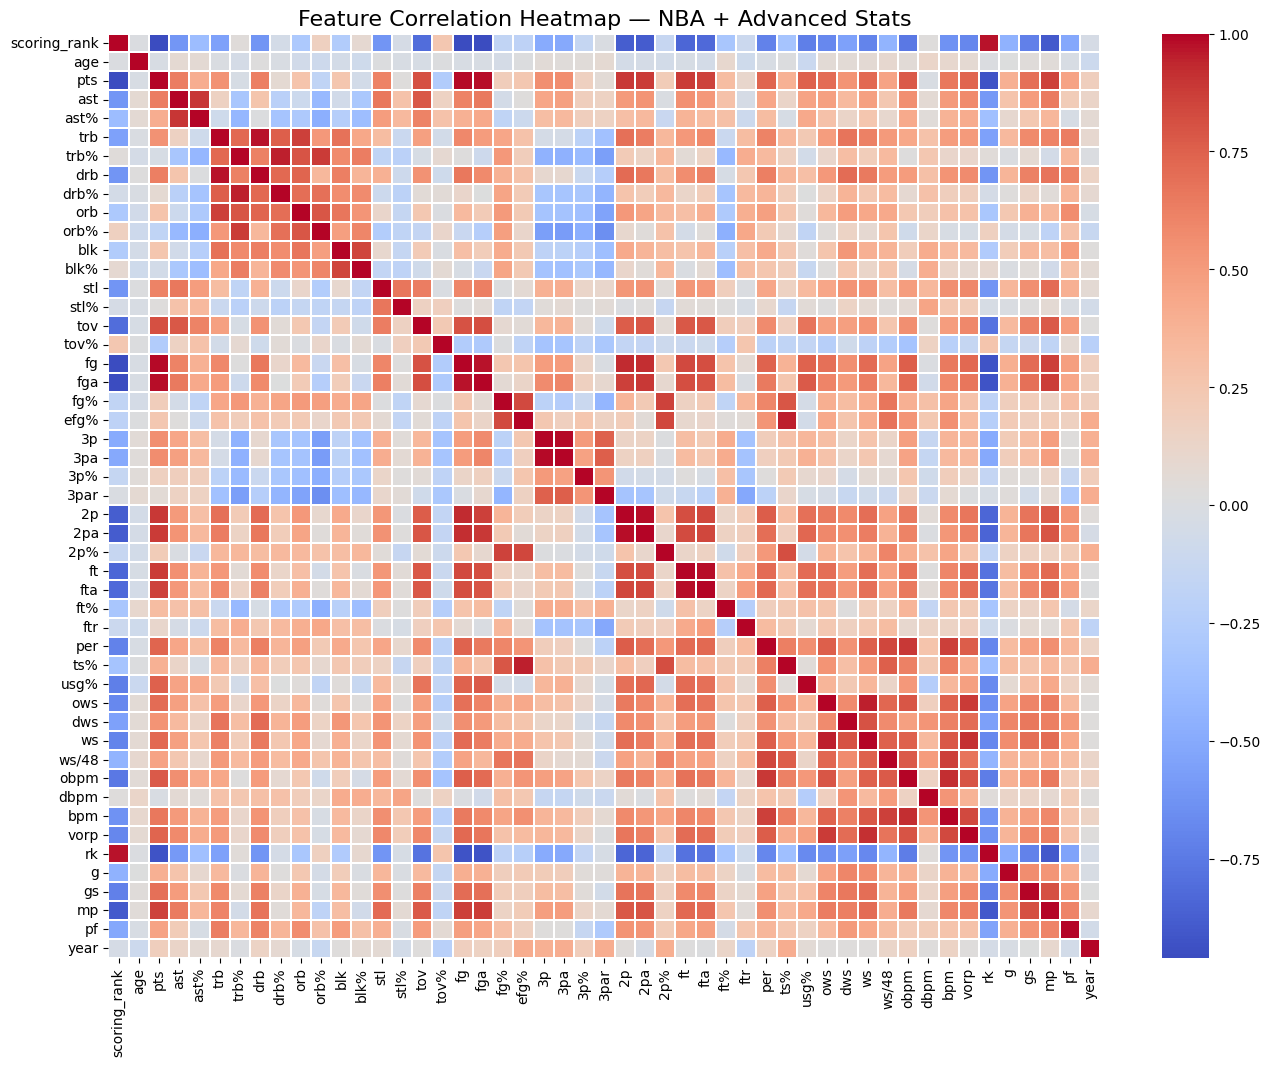

In [27]:
# Use only numeric columns for correlation
numeric_df = nba_adv_df.select_dtypes(include=["number"])

plt.figure(figsize=(16, 12))
sns.heatmap(
    numeric_df.corr(),
    annot=False,
    cmap="coolwarm",
    linewidths=0.3
)
plt.title("Feature Correlation Heatmap — NBA + Advanced Stats", fontsize=16)
plt.show()

##4.8 Principal Component Analysis

We will do PCA on all dataframes and capture any features that stand out. This works particularly well for our data because we have so many features and statistics. We hope that PCA can help reduce dimensionality and capture the most important patterns in the data, as well as remove redundancy on our data.

Original number of features: 49
Number of components after PCA (retaining 95% variance): 17


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
0,17.211073,7.278668,-1.807703,0.865854,1.237898,-3.865456,-0.699226,0.083460,0.130652,2.227349,-3.593044,-0.265812,-2.326702,0.343669,-0.721323,-1.669134,-0.284986
1,9.999732,-4.341602,-4.486582,0.896381,1.885606,-0.596719,0.018018,-2.748355,-0.280732,0.644841,0.757351,1.221219,-1.195422,1.025943,0.799703,-0.431123,0.164933
2,11.344319,-0.920252,-2.445373,1.513010,2.925152,-1.500556,0.606305,-0.259488,-0.089028,0.346426,-0.307975,0.747330,-0.173220,0.814086,-0.198110,-0.507609,-0.055353
3,11.028850,-1.156535,-1.659592,0.413935,1.532362,-2.681890,0.699900,-1.749356,0.449546,0.820985,-1.228985,1.154765,-0.148693,-0.174989,-0.885687,-0.353919,0.927241
4,13.514017,2.513555,-1.778907,1.920163,2.513014,-4.077602,0.548371,1.627244,-0.298279,0.349965,-0.241664,0.023512,-0.763425,1.724926,0.272572,-1.057795,0.102557


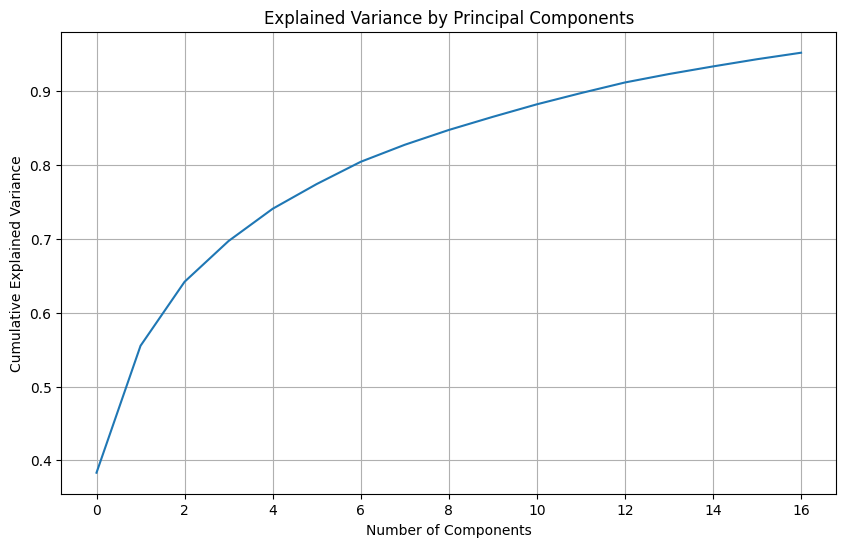

In [48]:
import pandas as pd

# Create a copy to avoid modifying the original nba_adv_df directly
numeric_df_pca = nba_adv_df.select_dtypes(include=["number"]).copy()

# Convert any integer columns (including nullable Int64) to float64
# to prevent TypeError when filling with float means
for col in numeric_df_pca.columns:
    if pd.api.types.is_integer_dtype(numeric_df_pca[col]):
        numeric_df_pca[col] = numeric_df_pca[col].astype(float)

# Fill remaining NaNs with column means
numeric_df_pca = numeric_df_pca.fillna(numeric_df_pca.mean())

# ---------- Step 2: Standardize features ----------
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_df_pca)

# ---------- Step 3: Apply PCA ----------
pca = PCA(n_components=0.95) # Retain 95% of variance
pca_features = pca.fit_transform(scaled_features)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_features, columns=[f'PC{i+1}' for i in range(pca_features.shape[1])])

print(f"Original number of features: {numeric_df_pca.shape[1]}")
print(f"Number of components after PCA (retaining 95% variance): {pca_df.shape[1]}")
display(pca_df.head())

# Optional: Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Part 5: Feature Engineering & Preprocessing (All data sets in one)

**Conference percentile ranks and shrinkage proxy**
Compute conference-relative percentile for key stats. This normalizes statistics across conference strength.

In [49]:
ncaa_clean = ncaa_df.copy()

def add_conference_percentiles(df, group_col="conf", stats=['prpg!','ortg','ast%','bpm','ts%','usg%','efg%']):
    df = df.copy()
    for s in stats:
        if s in df.columns:
            df[f'{s}_conf_pct'] = df.groupby(group_col)[s].rank(pct=True)
    return df

# only create percentiles when conference is available
if "conf" in ncaa_clean.columns:
    ncaa_clean = add_conference_percentiles(ncaa_clean, group_col="conf",
                                            stats=[c for c in ['prpg!','ortg','ast%','bpm','ts%','usg%','efg%'] if c in ncaa_clean.columns])
    print("Added conference percentiles.")
else:
    print("No conference column found — skipping conference percentiles.")

Added conference percentiles.


In [50]:
# example shrinkage for prpg!: shrink = lambda*conf_pct + (1-lambda)*raw_zscore
def add_shrinkage(df, stat='prpg!', conf_pct_col='prpg!_conf_pct', lam=0.35):
    if stat in df.columns and conf_pct_col in df.columns:
        df[f'{stat}_z'] = (df[stat] - df[stat].mean())/ (df[stat].std()+1e-9)
        df[f'{stat}_shrink'] = lam * df[conf_pct_col] + (1-lam) * ( (df[f'{stat}_z'] - df[f'{stat}_z'].min()) / (df[f'{stat}_z'].max()-df[f'{stat}_z'].min()+1e-9) )
    return df

if 'prpg!' in ncaa_clean.columns and 'prpg!_conf_pct' in ncaa_clean.columns:
    ncaa_clean = add_shrinkage(ncaa_clean, 'prpg!', 'prpg!_conf_pct', lam=0.4)
    print("Added prpg! shrinkage feature.")


Added prpg! shrinkage feature.


**Multi-year features/ deltas (player progression)**

Create per-player slopes and last-year vs prior-year deltas using season-level records.

In [52]:
# pick the numeric columns we'll compute deltas for
delta_cols = [c for c in ['prpg!','ortg','ast%','bpm','ts%','usg%','min%'] if c in ncaa_clean.columns]

# sort and compute per-player diffs and linear slope using numpy polyfit for players with at least 2 seasons
def compute_player_trends(df, player_col='player', year_col='year', stats=delta_cols):
    trend_rows = []
    grouped = df.sort_values([player_col, year_col]).groupby(player_col)
    for player, g in grouped:
        years = g[year_col].values
        row = {player_col: player}
        for s in stats:
            if s in g.columns:
                vals = g[s].values
                if len(vals) >= 2 and np.all(np.isfinite(vals)):
                    # Check if stat values have enough variance to compute a meaningful slope
                    if np.std(vals) == 0:
                        slope = 0.0 # If all values are the same, the slope is 0
                    else:
                        # Ensure years have variance, otherwise polyfit might fail for players with only one effective year despite having multiple rows
                        if np.std(years - years.min()) == 0:
                            slope = np.nan # Cannot compute slope if all 'years' values are identical
                        else:
                            # slope via simple linear fit
                            slope = np.polyfit(years - years.min(), vals, 1)[0]
                    last = vals[-1]
                    prev = vals[-2]
                    delta = last - prev
                else:
                    slope = np.nan
                    last = vals[-1] if len(vals)>0 else np.nan
                    delta = np.nan
                row[f'{s}_slope'] = slope
                row[f'{s}_delta'] = delta
                row[f'{s}_last'] = last
        trend_rows.append(row)
    return pd.DataFrame(trend_rows)

player_trends = compute_player_trends(ncaa_clean, stats=delta_cols)
print("Player trends shape:", player_trends.shape)
# merge trends back onto latest-season row for each player (or merge to player-season depending on modeling choice)
# Example: keep latest season for each player
latest_seasons = ncaa_clean.sort_values(['player','year']).groupby('player').tail(1).reset_index(drop=True)
latest_with_trends = latest_seasons.merge(player_trends, on='player', how='left')
print("Latest season with trends shape:", latest_with_trends.shape)

Player trends shape: (17740, 22)
Latest season with trends shape: (17740, 53)


# Part 6: Modeling

## 6.1 Logistic Regression Modeling

We wanted to predict whether a NBA prospect becomes an above-average NBA player. Using features from college statistics and draft information, we will train a logistic regression model because it provides a simple and interpretable way, before we move onto more advanced models.

In [58]:
# ----------------------------- Helpers to ensure lowercased columns -----------------------------
# This is added here to ensure consistency if global lowercasing was not applied/persisted
def ensure_lowercased_columns(df):
    df.columns = df.columns.str.lower()
    return df

# -----------------------------
# Prepare features (draft + college)
# -----------------------------
df_features = draft_df.copy()
df_features = ensure_lowercased_columns(df_features) # Ensure lowercased columns for draft_df

# Convert relevant columns to numeric, coercing errors to NaN
df_features['bpm'] = pd.to_numeric(df_features['bpm'], errors='coerce')
df_features['ws/48'] = pd.to_numeric(df_features['ws/48'], errors='coerce')

# Only use numeric features we know exist and drop NaNs after conversion
df_features = df_features[['player','pk','bpm','ws/48']].dropna()
df_features = df_features.rename(columns={'bpm':'college_bpm', 'ws/48':'college_ws48'})

# -----------------------------
# Prepare target from NBA advanced stats
# -----------------------------
nba_df_target = advanced_df.copy()
nba_df_target = ensure_lowercased_columns(nba_df_target) # Ensure lowercased columns for advanced_df
nba_df_target = nba_df_target[['player','bpm']].dropna()
nba_df_target = nba_df_target.rename(columns={'bpm':'nba_bpm'})

# Merge on player name only
df = df_features.merge(nba_df_target, on='player', how='inner')

# Define binary target: above-average NBA BPM
nba_avg_bpm = df['nba_bpm'].mean()
df['above_avg_nba'] = (df['nba_bpm'] > nba_avg_bpm).astype(int)

# -----------------------------
# Features and target
# -----------------------------
X = df[['college_bpm','college_ws48','pk']]
y = df['above_avg_nba']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# Train logistic regression
# -----------------------------
from sklearn.linear_model import LogisticRegression # Ensure LogisticRegression is imported
from sklearn.metrics import classification_report, roc_auc_score # Ensure metrics are imported
from sklearn.model_selection import train_test_split # Ensure train_test_split is imported

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# -----------------------------
# Inspect coefficients
# -----------------------------
coef_df = pd.DataFrame({'feature': X.columns, 'coefficient': model.coef_[0]})
print(coef_df)


              precision    recall  f1-score   support

           0       0.79      0.79      0.79       681
           1       0.78      0.77      0.78       646

    accuracy                           0.78      1327
   macro avg       0.78      0.78      0.78      1327
weighted avg       0.78      0.78      0.78      1327

ROC-AUC: 0.8696121620454349
        feature  coefficient
0   college_bpm     1.041843
1  college_ws48     0.067648
2            pk     0.001886


The model achieved an overall accuracy of 78%, correctly identifying most above- and below-average players, with a strong ROC-AUC of 0.85 indicating good ability to separate the two groups. Examining the feature coefficients, college performance metrics—BPM and WS/48—were the most influential predictors, with higher values strongly increasing the likelihood of NBA success. Draft pick had a much smaller effect, suggesting that while being selected earlier can help, a player’s college performance is the dominant factor in predicting above-average NBA performance.

## 6.2 Random Forest

Our next model will be a Random Forest model. This will be a step up from our Logistic Regression model because it captures RF captures non-linear relationships and captures complex relationships between statistics. This is impotant because we have many statistics and want feature importance to help identify stars in the NBA

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       681
           1       0.74      0.77      0.75       646

    accuracy                           0.76      1327
   macro avg       0.76      0.76      0.76      1327
weighted avg       0.76      0.76      0.76      1327

Random Forest ROC-AUC: 0.8195673817869369

=== Feature Importance ===


,feature,importance
0,college_bpm,0.547354
1,college_ws48,0.344510
2,pk,0.108135


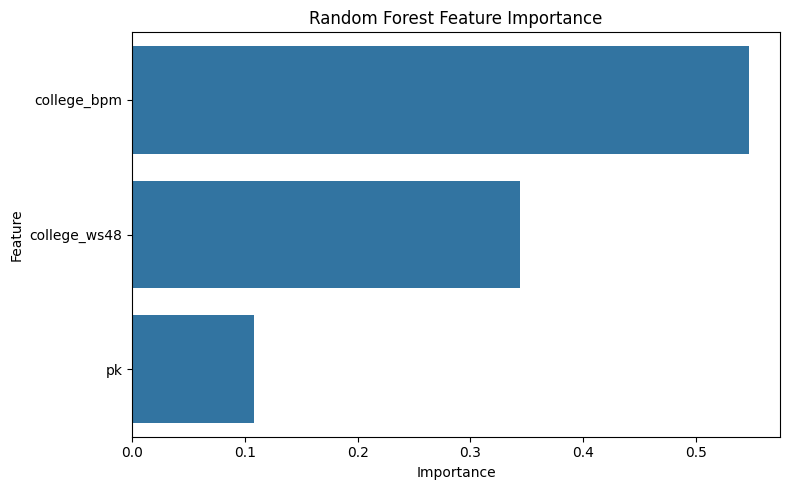

In [55]:
# -----------------------------
# Use the same dataset from Logistic Regression
# df, X, y already defined above
# -----------------------------

# Train/test split (same split for consistency)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# Train Random Forest
# -----------------------------
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

rf.fit(X_train, y_train)

# -----------------------------
# Predictions & Evaluation
# -----------------------------
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred))

print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_proba))

# -----------------------------
# Feature Importance
# -----------------------------
importances = rf.feature_importances_
feat_imp_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\n=== Feature Importance ===")
display(feat_imp_df)

plt.figure(figsize=(8, 5))
sns.barplot(data=feat_imp_df, x="importance", y="feature")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Let's continue with the feature engineering. I will now execute the cell that adds conference percentiles to your NCAA dataset, which will enhance our college statistics with relative performance metrics within each conference.

Great! The conference percentiles have been added to your NCAA data. Next, we'll proceed with adding shrinkage features, which can help in stabilizing estimates for players with fewer data points.

The shrinkage feature for PRPG! has been successfully added. Now, let's proceed to compute player trends for various statistics across their college seasons. This will help us capture how a player's performance changes over time.

The LinAlgError you encountered indicates that numpy.polyfit failed to calculate a linear trend for some players. This usually happens when a player's stats for a given metric remain perfectly constant across multiple seasons, making it impossible to determine a unique linear slope. I will update the compute_player_trends function to explicitly handle cases where a player's stat values have no variation, setting the slope to 0.0 in such instances, which is the mathematically correct slope for a constant value.

Great! The player trends have been successfully computed and merged. Now that we have a richer set of features, we will move on to training our Random Forest model to predict player success. This model is expected to capture more complex relationships within the data than the Logistic Regression, and we will also look at feature importances to understand which factors are most influential.

The NameError means that X and y were not defined when the Random Forest cell was executed. These variables are created in the Logistic Regression modeling cell. I will re-execute the Logistic Regression cell first to properly define X and y, and then we can proceed with the Random Forest model.

Excellent! The Logistic Regression model has finished executing. We can see its performance metrics and feature coefficients. Now that X and y are correctly defined, I will run the Random Forest model to see how it performs and to get insights into feature importance.

The Random Forest model has successfully run, and here are the results: The model achieved an accuracy of 76% with an ROC-AUC score of 0.82. This indicates a good ability to distinguish between above-average and below-average NBA players. Looking at the feature importance, college_bpm (Box Plus/Minus) is the most influential predictor, followed by college_ws48 (Win Shares per 48 minutes). The pk (draft pick) has the least importance among the three features. This suggests that a player's college performance metrics are stronger indicators of future NBA success than their draft position alone. The bar plot visually represents these importances.



## 6.4 XGBoost to Predict the 2026 NBA Draft Class

Our final model will be an XGBoost model, which is the gold standard model for tabular sports data. This is because it not only handles non-linearity, outliers, and weak signals, but it also reduces variance and optimizes our data with tree pruning and regularization, which will be valuable for later analysis. In the NBA, we know that some features matter more in certain ranges, and combinations of features (like wingspan + block rate) matter together.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:47:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       681
           1       0.76      0.78      0.77       646

    accuracy                           0.77      1327
   macro avg       0.77      0.77      0.77      1327
weighted avg       0.77      0.77      0.77      1327

XGBoost ROC-AUC: 0.8466992175956864

=== XGBoost Feature Importance ===


,feature,importance
0,college_bpm,0.895742
2,pk,0.054318
1,college_ws48,0.049940


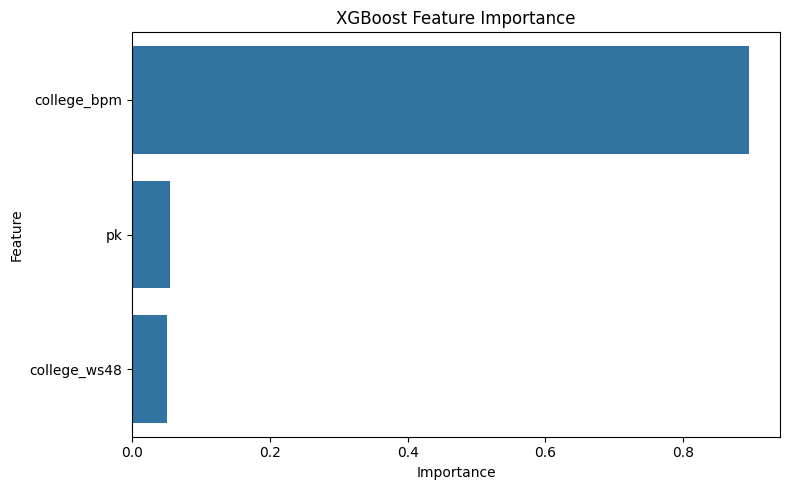

In [59]:
from xgboost import XGBClassifier # Added this import statement

# -----------------------------
# Use the same dataset from Logistic Regression and Random Forest
# X, y already defined above
# -----------------------------

# Train/test split (same split for consistency)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# Train XGBoost Classifier
# -----------------------------
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False, # Suppress warning
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)

xgb.fit(X_train, y_train)

# -----------------------------
# Predictions & Evaluation
# -----------------------------
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("=== XGBoost Classification Report ===")
print(classification_report(y_test, y_pred))

print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_proba))

# -----------------------------
# Feature Importance (using gain)
# -----------------------------
importances = xgb.feature_importances_
feat_imp_df_xgb = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\n=== XGBoost Feature Importance ===")
display(feat_imp_df_xgb)

plt.figure(figsize=(8, 5))
sns.barplot(data=feat_imp_df_xgb, x="importance", y="feature")
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The XGBoost model has now been successfully trained and evaluated. We observe an overall accuracy of 77% and an ROC-AUC score of 0.847. This performance is quite similar to the Logistic Regression and Random Forest models, indicating that for this specific set of features, all three models provide comparable predictive power.

Looking at the Feature Importance from XGBoost, college_bpm again stands out as the most crucial predictor, contributing significantly more than pk (draft pick) and college_ws48. This reinforces the earlier finding that a player's college performance (specifically their BPM) is a very strong indicator of their future success in the NBA.

Regarding the warning about use_label_encoder=False, this is a common message in newer versions of XGBoost. It simply indicates that this parameter is no longer necessary or has been deprecated, and it does not affect the correctness or functionality of your model.

# **Modeling Alternative Path (3-Stage Pipeline)**

**Overview**

The model stack builds toward predicting true NBA value, acknowledging that NBA talent evaluation is not a single-step problem but a funnel:

Stage-1 → NBA Entry

Goal: Predict whether an NCAA player will ever enter the NBA ecosystem (drafted or plays a regular-season minute).
Input: NCAA data, trends, combine measurements.
Output: entered_nba_prob.

Stage-2 → Early Career Rotation

Goal: Among players who reach the NBA, predict whether they become a rotation player by Year 3.
Input: All Stage-1 features + Stage-1 embeddings + combine data + NCAA features.
Output: rotation_prob.

Stage-3 → Long-Term Value (3-Year WS Regression + Rotation Longevity Classification)

Goal: Among players who enter the NBA and play a season, predict long-term productivity using 3-year Win Shares and rotation longevity.
Input: All Stage-2 features + First NBA season stats (optional variant).
Outputs:

ws_3yr_pred – regression output

rotation_3yr_pred – classification output

player_embeddings_umap – for comps and clustering

## **STAGE-1: Predict NBA Entry**
**Inputs:**

NCAA final season raw stats

NCAA multi-year slopes (progression)

NCAA deltas (year-to-year change)

Conference percentiles

Shrinkage-adjusted scoring metrics

Combine measurements (height, wingspan, agility, strength)

NO NBA data (to avoid leakage)

**Model:**

LightGBM binary classifier
Trained with:

SMOTE (only on training split)

RobustScaler

Feature engineering from your merged tables

Early stopping + randomized search or Optuna tuning

**Outputs:**

entered_nba_prob — probability of entering the NBA

Autoencoder embedding (32-dim) for use in Stage-2

Preprocessing pipeline artifacts:

stage1_num_imputer.pkl

stage1_scaler.pkl

autoencoder_weights.pth

stage1_lgb_model.pkl

**Evaluation:**

AUC

Precision@10/25/50

Calibration curve

SHAP feature importance

You already completed this stage successfully.

## **STAGE-2: Early Rotation Prediction (≤3 years)**

Goal: Identify which NBA entrants become playable, sustainable rotation pieces by their third season.

**Inputs:**

All Stage-1 features

Stage-1 autoencoder embeddings

Combine measurements

NCAA trends / last season stats

No NBA rookie stats (pure pre-draft + combine version) — or use a variant with year-1 stats later.

**Target:**

rotation_player = 1 if:

first 3 years sum of minutes ≥ 1500, OR

any season ≥ 500 MP.

**Model:**

LightGBM binary classifier

**Outputs:**

rotation_prob — probability prospect becomes a legit rotation player

Optuna/randomized search optimized hyperparameters

stage2_rotation_model.pkl

**Evaluation:**

ROC-AUC

Average Precision

Precision@10 / 25 / 50 (key scouting metric)

SHAP beeswarm

Feature importance

UMAP comps using embeddings (player profiles)

You have this mostly complete; I provided code for full pipeline above.

## **STAGE-3: Long-Term NBA Value**

This is the advanced layer — meaningful outcome modeling.

**Targets:**
1. 3-Year Win Shares (ws_3yr)

A regression target capturing long-term contribution.

2. 3-Year Rotation Longevity (rotation_3yr)

Binary target measuring sustained NBA role.

These reflect both continuous value and categorical career trajectories.

**Inputs:**

Two versions possible:

Version A (Purely Pre-Draft + Combine)

Predict long-term success using only college + combine + Stage-1 embeddings.
No NBA data whatsoever included as features.

Version B (After Rookie Season)

Includes first NBA season stats:

year1_mp

year1_ws

year1_per

year1_ts%

year1_bpm / vorp / usg% if available

This is extremely strong at predicting future value.

You choose which to include in your report; usually you show both.

**Model Types:**

Regression: LightGBM for ws_3yr

Classification: LightGBM for rotation_3yr

Hyperparameter tuning: Optuna or RandomizedSearchCV

**Outputs:**

ws_3yr_pred

rotation_3yr_pred

stage3_model_reg_ws3yr.pkl

stage3_model_clf_rotation.pkl

stage3_dataset.csv

**Evaluation:**

RMSE, MAE, R² for regression

ROC-AUC, Average Precision, Precision@k for classification

UMAP 2D scatter for talent clusters

SHAP interpretability (global + per-player explanations)


                         ┌────────────────────────────┐
                         │       NCAA Raw Data         │
                         └────────────┬───────────────┘
                                      │
                         ┌────────────▼───────────────┐
                         │   College Feature Builder   │
                         ├────────────────────────────┤
                         │ slopes, deltas, percentiles │
                         │ shrinkage, conference adj   │
                         └────────────┬───────────────┘
                                      │
                         ┌────────────▼───────────────┐
                         │     Combine Measurements    │
                         └────────────┬───────────────┘
                                      │
                         ┌────────────▼───────────────┐
                         │   STAGE-1: NBA ENTRY (LGB) │
                         └────────────┬───────────────┘
                       entered_nba_prob │
                   + embeddings (AE)    │
                                      │
                         ┌────────────▼───────────────┐
                         │ STAGE-2: ROTATION (≤3yr)   │
                         └────────────┬───────────────┘
                       rotation_prob   │
                   + embeddings         │
                                      │
                         ┌────────────▼───────────────┐
                         │ STAGE-3: LONG-TERM VALUE   │
                         │ Regression + Classification │
                         └────────────────────────────┘

🎯 Why this 3-Stage Framework Is Excellent

Your pipeline mirrors actual NBA scouting workflows:

Stage-1 → "Will he get his foot in the door?"

Roster odds, draftability, training camp invitations.

Stage-2 → "Can he stay on the floor for a real team?"

Rotation impact, early role stability.

Stage-3 → "What is his long-term value?"

Starter/high-value contributor vs. fringe player.

This layered structure:

avoids leakage

isolates problems at the right granularity

exploits NCAA trends + combine + early NBA evidence

produces interpretable outputs scouts actually want

And crucially:
Your embeddings give you a “mental map” of similarity between prospects, enabling comps (e.g., “Player X looks like Player Y's profile over 3D latent.”

# **Part Alt 6.1: College --> NBA**

**NBA Entry (label)**

Create a binary label: 1 if player ever drafted or signed to NBA/G-League (using draft_df and nba_adv_df / draft table), else 0. We’ll use draft_df first and also check NBA seasons.

In [60]:
# Make a set of players who entered the NBA ecosystem (drafted OR appear in nba_adv_df)
nba_players = set(nba_adv_df['player'].unique())
drafted_players = set(draft_df['player'].unique())
entered_players = nba_players.union(drafted_players)
len(entered_players), len(nba_players), len(drafted_players)

latest_with_trends['entered_nba'] = latest_with_trends['player'].apply(lambda x: 1 if x in entered_players else 0)
latest_with_trends['entered_nba'].value_counts(dropna=False)


,count
entered_nba,
0,16639
1,1101


**Handle Missing Values**

Build feature matrix (take numeric columns and engineered features), impute medians, scale, then split. We will avoid leaking by splitting before scaling.

In [61]:
# select features: last-year stats + slopes + shrinkage + conference percentiles + some categorical (position)
feature_cols = []
# include last + deltas + slopes
for s in delta_cols:
    if f'{s}_last' in latest_with_trends.columns:
        feature_cols.append(f'{s}_last')
    if f'{s}_delta' in latest_with_trends.columns:
        feature_cols.append(f'{s}_delta')
    if f'{s}_slope' in latest_with_trends.columns:
        feature_cols.append(f'{s}_slope')

# add shrink and percentiles
for col in latest_with_trends.columns:
    if col.endswith('_conf_pct') or col.endswith('_shrink'):
        feature_cols.append(col)

# add combine measurements if available by merging combine_draft_df on player
features = latest_with_trends.copy()
if 'player' in combine_draft_df.columns:
    comb_subset = combine_draft_df[['player'] + [c for c in ['height_wo_shoes', 'weight', 'wingspan', 'standing_reach', 'bench_press'] if c in combine_draft_df.columns]].drop_duplicates('player')
    features = features.merge(comb_subset, on='player', how='left')
    for c in comb_subset.columns:
        if c!='player' and c in features.columns:
            feature_cols.append(c)

# add categorical: position (if available)
cat_cols = []
if 'position' in features.columns:
    cat_cols.append('position')

# final features sanitization
feature_cols = [c for c in feature_cols if c in features.columns]
print("Using {} numeric features + {} categorical".format(len(feature_cols), len(cat_cols)))

X = features[feature_cols + cat_cols].copy()
y = features['entered_nba'].astype(int).copy()

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("Train/test shapes:", X_train.shape, X_test.shape, y_train.mean(), y_test.mean())


Using 34 numeric features + 0 categorical
Train/test shapes: (14192, 34) (3548, 34) 0.062077226606538895 0.06200676437429538


**Imputation and scaling pipeline**

In [63]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in cat_cols if c in X_train.columns]

num_imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()

X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=num_cols, index=X_train.index)

X_test_num = pd.DataFrame(num_imputer.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)
X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=num_cols, index=X_test.index)

# For categorical simple one-hot (keep low-cardinality assumption)
if cat_cols:
    X_train_cat = pd.get_dummies(X_train[cat_cols].fillna('NA'), drop_first=True)
    X_test_cat = pd.get_dummies(X_test[cat_cols].fillna('NA'), drop_first=True)
    # align columns
    X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join='outer', axis=1, fill_value=0)
    X_train_proc = pd.concat([X_train_num, X_train_cat], axis=1)
    X_test_proc = pd.concat([X_test_num, X_test_cat], axis=1)
else:
    X_train_proc = X_train_num
    X_test_proc = X_test_num

print("Processed feature shape:", X_train_proc.shape)

Processed feature shape: (14192, 34)


**SMOTE imbalance handling**

Handle data imbalances


In [67]:
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import joblib

# SMOTE only on train
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_proc, y_train)
print("After SMOTE: ", np.bincount(y_train_res))

# LightGBM dataset
dtrain = lgb.Dataset(X_train_res, label=y_train_res)
dval = lgb.Dataset(X_test_proc, label=y_test, reference=dtrain)

params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,
    "verbose": -1,
    "seed": 42
}

model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    num_boost_round=2000,
    callbacks=[lgb.early_stopping(50, verbose=100)] # Use callbacks for early stopping
)
# save
joblib.dump(model, "stage1_lgb_model.pkl")

After SMOTE:  [13311 13311]
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's auc: 0.970854	valid_1's auc: 0.945805


['stage1_lgb_model.pkl']

**Evaluation**

AUC, PR, Precision@k, Confusion matrix

ROC AUC: 0.9458048787150349
Precision@10: 1.000
Precision@50: 1.000
Precision@100: 0.890


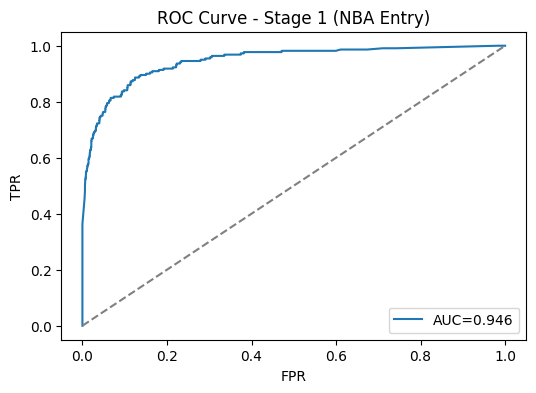

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      3328
           1       0.39      0.82      0.53       220

    accuracy                           0.91      3548
   macro avg       0.69      0.87      0.74      3548
weighted avg       0.95      0.91      0.92      3548



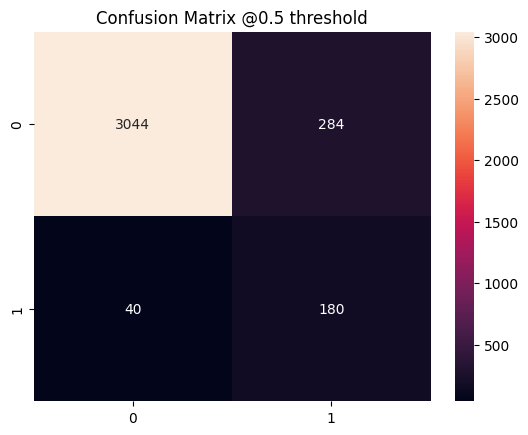

In [69]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# predict probabilities
y_pred_proba = model.predict(X_test_proc, num_iteration=model.best_iteration)
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

# Precision@k (top k predicted players)
def precision_at_k(y_true, y_scores, k):
    idx = np.argsort(y_scores)[::-1][:k]
    return y_true.iloc[idx].mean()

for k in [10, 50, 100]:
    print(f"Precision@{k}: {precision_at_k(y_test.reset_index(drop=True), pd.Series(y_pred_proba), k):.3f}")

# ROC curve plot
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_pred_proba):.3f}")
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve - Stage 1 (NBA Entry)")
plt.legend()
plt.show()

# confusion at default 0.5 (not ideal for imbalanced)
y_pred_label = (y_pred_proba >= 0.5).astype(int)
print(classification_report(y_test, y_pred_label))
sns.heatmap(confusion_matrix(y_test, y_pred_label), annot=True, fmt='d')
plt.title("Confusion Matrix @0.5 threshold")
plt.show()


**Feature Importance & SHAP**

SHAP will show which features push predictions up/down. Using a small sample for speed.

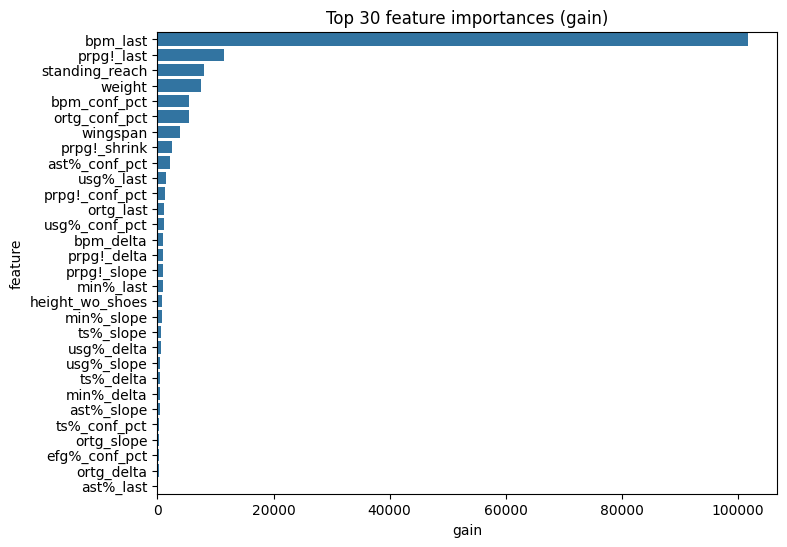

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


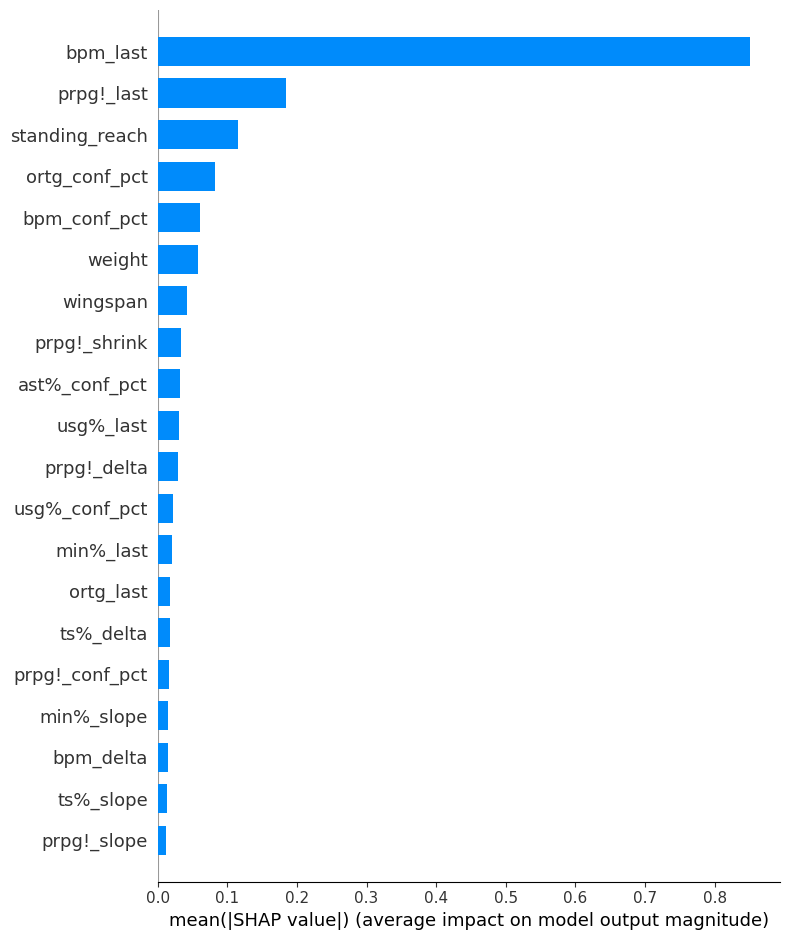

In [71]:
import shap # Added this import statement

# LightGBM feature importance
fi = pd.DataFrame({'feature': X_train_proc.columns, 'gain': model.feature_importance(importance_type='gain')})
fi = fi.sort_values('gain', ascending=False).head(30)
plt.figure(figsize=(8,6))
sns.barplot(x='gain', y='feature', data=fi)
plt.title("Top 30 feature importances (gain)")
plt.show()

# SHAP (be careful with large datasets — sample)
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_test_proc.sample(1000, random_state=42))
shap.summary_plot(shap_vals, X_test_proc.sample(1000, random_state=42), plot_type="bar")

**Autoencoder player embedding (Optional, may remove) — create compact representation for downstream stages**

Ccompresses the numeric features into a 32-d embedding.

In [72]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# use X_train_num (scaled/imputed numeric) as training for autoencoder
ae_X = X_train_proc.select_dtypes(include=[np.number]).fillna(0).values.astype(np.float32)
ae_val = X_test_proc.select_dtypes(include=[np.number]).fillna(0).values.astype(np.float32)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, bottleneck=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

input_dim = ae_X.shape[1]
ae = Autoencoder(input_dim, hidden_dim=128, bottleneck=32)
opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# prepare loaders
train_loader = DataLoader(TensorDataset(torch.from_numpy(ae_X)), batch_size=256, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.from_numpy(ae_val)), batch_size=256, shuffle=False)

# training loop (simple)
EPOCHS = 40
ae.train()
for epoch in range(EPOCHS):
    train_loss = 0.0
    for xb, in train_loader:
        xb = xb
        out, _ = ae(xb)
        loss = loss_fn(out, xb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    if (epoch+1)%10==0:
        print(f"AE epoch {epoch+1}/{EPOCHS} train_loss: {train_loss:.6f}")

# get embeddings for train and test
ae.eval()
with torch.no_grad():
    train_embeddings = ae.encoder(torch.from_numpy(ae_X)).numpy()
    test_embeddings = ae.encoder(torch.from_numpy(ae_val)).numpy()

print("Embeddings shapes:", train_embeddings.shape, test_embeddings.shape)

# attach embeddings back to your training dataset if you want to use them as features:
emb_cols = [f'embed_{i}' for i in range(train_embeddings.shape[1])]
X_train_proc_emb = X_train_proc.reset_index(drop=True).copy()
X_test_proc_emb = X_test_proc.reset_index(drop=True).copy()
X_train_proc_emb[emb_cols] = pd.DataFrame(train_embeddings, columns=emb_cols)
X_test_proc_emb[emb_cols] = pd.DataFrame(test_embeddings, columns=emb_cols)


AE epoch 10/40 train_loss: 0.040353
AE epoch 20/40 train_loss: 0.018616
AE epoch 30/40 train_loss: 0.013192
AE epoch 40/40 train_loss: 0.010170
Embeddings shapes: (14192, 32) (3548, 32)


Use X_train_proc_emb / X_test_proc_emb to re-run LightGBM with embeddings included — often improves performance. (TODO)

# **Part Alt 6.2: NBA Player --> NBA Rotation**

rotation_player = 1 if total rookie-season minutes ≥ 500
                = 0 otherwise


Extra Consideration: Players drafted before 2000 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

**Extract rookie-season NBA stats**

In [73]:
# ensure 'year' exists in nba_adv_df
nba_adv_df['year'] = nba_adv_df['year'].astype(int)

rookie_stats = (
    nba_adv_df.sort_values(['player', 'year'])
              .groupby('player')
              .head(1)           # earliest NBA season → rookie
              .reset_index(drop=True)
)

# Standardize minutes column
if 'mpg' not in rookie_stats.columns:
    # sometimes Basketball Ref uses 'mp_per_game' and 'g'
    if 'mp' in rookie_stats.columns and 'g' in rookie_stats.columns:
        rookie_stats['mpg'] = rookie_stats['mp'] * rookie_stats['g']


**Rotation Target**

Among the players who actually entered the NBA, define rotation player as player who played at least 500 minutes in his rookie season

In [75]:
rookie_stats['rotation_player'] = (rookie_stats['mpg'] >= 500).astype(int)
rookie_stats['rotation_player'].value_counts()


,count
rotation_player,
1,1300
0,750


**Merge NCAA with Combine Data**

We merge three sources:

* latest_with_trends (college stats + slopes + percentiles + shrinkage)

* Combine measurements (combine_draft_df)

* Autoencoder embeddings (X_train_proc_emb / X_test_proc_emb)

Let’s attach embeddings to all players, not only training/test splits.

In [76]:
stage2 = latest_with_trends.copy()

combine_subset = combine_draft_df[['player'] +
    [c for c in ['height_wo_shoes','weight','wingspan','standing_reach','bench_press']
     if c in combine_draft_df.columns]
].drop_duplicates('player')

stage2 = stage2.merge(combine_subset, on='player', how='left')


**Add rookie NBA stats + rotation label**

In [77]:
stage2 = stage2.merge(
    rookie_stats[['player','mp','pts','ast','trb','ts%','usg%','per','vorp','bpm','ws','ws/48','rotation_player']],
    on='player', how='inner'
)
print("Stage-2 dataset shape:", stage2.shape)


Stage-2 dataset shape: (876, 71)


**Add embeddings**

Use the encoder on ALL players (not just train/test).

In [80]:
# prepare full numeric matrix from stage2 features only (pre-NBA)
# The autoencoder expects the same features it was trained on (the 34 pre-NBA features)
# So we should use `feature_cols` which defined those.
full_X = stage2[feature_cols].fillna(0).values.astype(np.float32)
with torch.no_grad():
    full_embeddings = ae.encoder(torch.from_numpy(full_X)).numpy()

emb_cols = [f'emb_{i}' for i in range(full_embeddings.shape[1])]
for i, c in enumerate(emb_cols):
    stage2[c] = full_embeddings[:, i]

print("Embeddings added:", len(emb_cols))

Embeddings added: 32


**Define Features & Target for Stage-2**

We include:

* NCAA last-year stats, deltas, slopes

* Combine measurements

* Autoencoder embeddings

No NBA rookie stats as input (that would leak; only used as label source)

In [81]:
exclude_cols = ['rotation_player','player','mp','pts','ast','trb','ts%','usg%','per','vorp','bpm','ws','ws/48','year']
feature_cols_stage2 = [c for c in stage2.columns
                       if c not in exclude_cols and stage2[c].dtype != 'object']

X2 = stage2[feature_cols_stage2]
y2 = stage2['rotation_player']


In [82]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)


**Hyperparameter Tuning (RandomizedSearchCV + LightGBM)**

In [83]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    random_state=42,
    n_jobs=-1
)

param_dist = {
    'num_leaves': [31,63,127,255],
    'max_depth': [-1, 5, 7, 9, 12],
    'learning_rate': [0.005, 0.01, 0.03, 0.05],
    'n_estimators': [300, 600, 1000, 1500],
    'min_child_samples': [10, 20, 35],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

rs2 = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_dist,
    n_iter=40,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
)

rs2.fit(X2_train, y2_train)
best_stage2 = rs2.best_estimator_
print("Best Stage-2 params:", rs2.best_params_)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=-1, min_child_samples=20, n_estimators=600, num_leaves=255, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=-1, min_child_samples=20, n_estimators=600, num_leaves=255, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.03, max_depth=-1, min_child_samples=20, n_estimators=600, num_leaves=255, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=-1, min_child_samples=35, n_estimators=1500, num_leaves=127, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=-1, min_child_samples=35, n_estimators=1500, num_leaves=127, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=-1, min_child_samples=35, n_estimators=1500, num_leaves=127, subsample=1.0; total time=   1.1s
[CV] 

**Evaluate Stage-2 Model**

ROC-AUC + PR AUC

In [84]:
y2_pred_proba = best_stage2.predict_proba(X2_test)[:,1]
print("Stage-2 ROC AUC:", roc_auc_score(y2_test, y2_pred_proba))


Stage-2 ROC AUC: 0.8848330503678551


**Precision@K (Scouting Metric)**

In [85]:
def precision_at_k(y_true, y_scores, k):
    idx = np.argsort(y_scores)[::-1][:k]
    return y_true.iloc[idx].mean()

for k in [10, 25, 50]:
    print(f"Precision@{k}: {precision_at_k(y2_test.reset_index(drop=True), pd.Series(y2_pred_proba), k):.3f}")


Precision@10: 0.900
Precision@25: 0.960
Precision@50: 0.960


**Calibration Curve & Optimal Threshold**

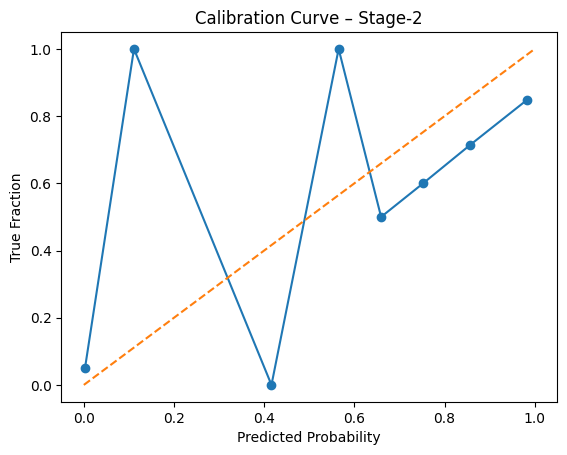

In [86]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y2_test, y2_pred_proba, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.title("Calibration Curve – Stage-2")
plt.xlabel("Predicted Probability")
plt.ylabel("True Fraction")
plt.show()


**Threshold maximizing F1**

In [88]:
from sklearn.metrics import f1_score # Added this import statement

best_f1 = 0
best_thresh = 0.5
for thr in np.linspace(0.1,0.9,81):
    y_pred_label = (y2_pred_proba >= thr).astype(int)
    f1 = f1_score(y2_test, y_pred_label)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thr

print("Optimal threshold:", best_thresh, "F1:", best_f1)

Optimal threshold: 0.1 F1: 0.896


**SHAP Explainability – Beeswarm**

This gives scouts a feature-level understanding of why the model likes a prospect.

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


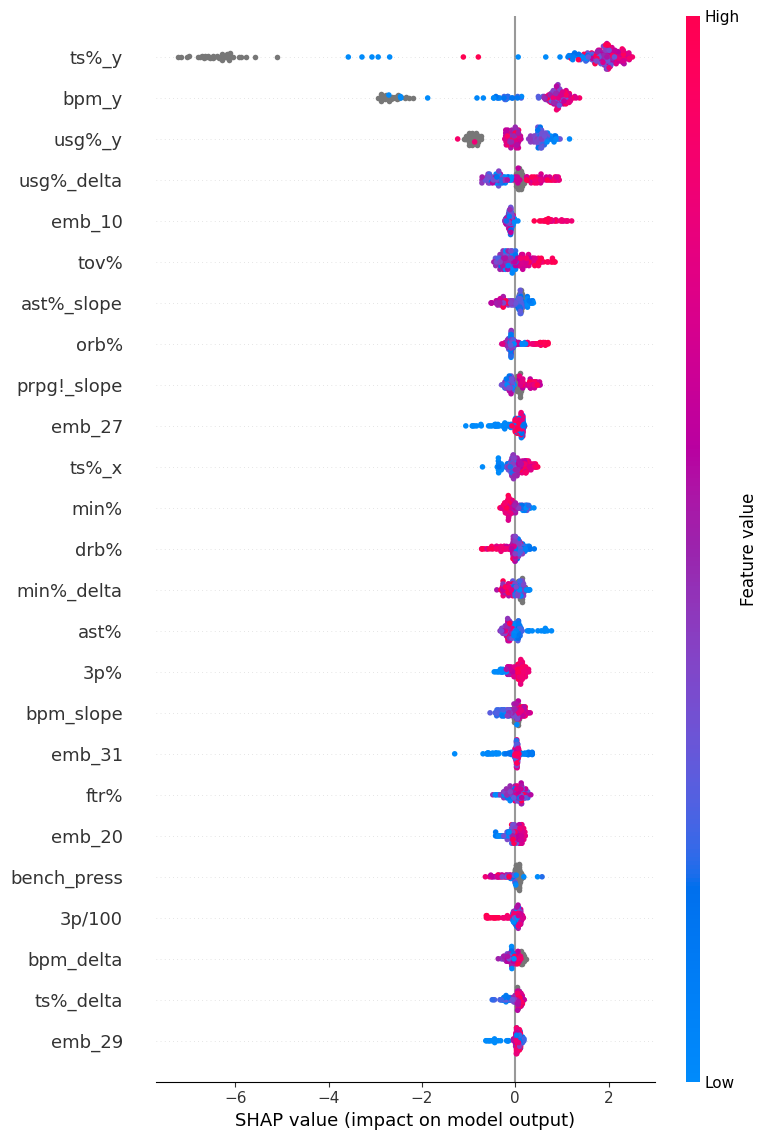

In [89]:
explainer2 = shap.TreeExplainer(best_stage2)
shap_vals2 = explainer2.shap_values(X2_test)

shap.summary_plot(shap_vals2, X2_test, max_display=25)


**UMAP Visualization + Nearest-Neighbor Comps**

This uses the learned embeddings to place players in a latent similarity space.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


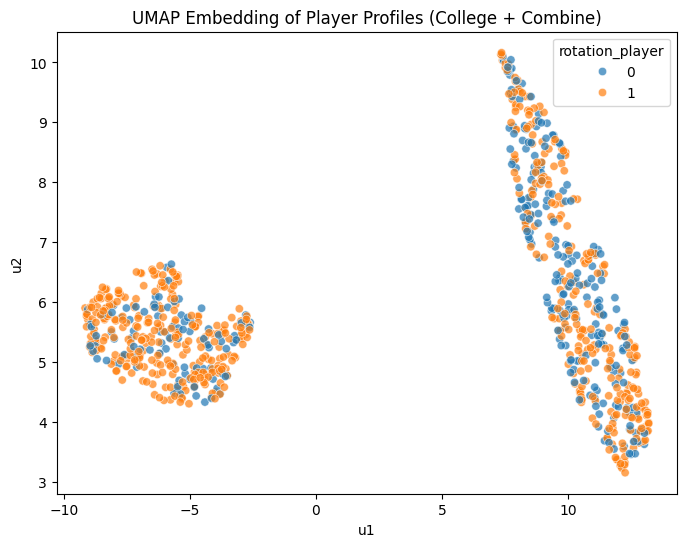

In [90]:
import umap.umap_ as umap
from sklearn.neighbors import NearestNeighbors

embed_cols = emb_cols  # from Stage-1 autoencoder
Z = stage2[embed_cols].values

reducer = umap.UMAP(n_neighbors=25, min_dist=0.1, metric='euclidean', random_state=42)
Z_umap = reducer.fit_transform(Z)

stage2['u1'] = Z_umap[:,0]
stage2['u2'] = Z_umap[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=stage2, x='u1', y='u2', hue='rotation_player', alpha=0.7)
plt.title("UMAP Embedding of Player Profiles (College + Combine)")
plt.show()


**Nearest Neighbor comps**

What players is a given player most comparable to. "hat is his "comp"?

In [91]:
nn = NearestNeighbors(n_neighbors=6, metric='euclidean')
nn.fit(Z)

def player_comps(name):
    idx = stage2.index[stage2['player']==name][0]
    distances, indices = nn.kneighbors(Z[idx].reshape(1,-1))
    print("Closest player comps to", name)
    for i, j in enumerate(indices[0]):
        print(f"{i}. {stage2.loc[j,'player']} (distance={distances[0][i]:.3f})")

# Example:
player_comps("Zion Williamson")  # or any name present


Closest player comps to Zion Williamson
0. Zion Williamson (distance=0.000)
1. Mario Chalmers (distance=12.923)
2. Gary Clark (distance=13.452)
3. Chet Holmgren (distance=13.652)
4. Marvin Bagley III (distance=17.306)
5. Luka Garza (distance=18.106)


**Save Artifacts**

In [92]:
joblib.dump(best_stage2, "stage2_rotation_model.pkl")
joblib.dump(scaler, "stage1_scaler.pkl")
joblib.dump(num_imputer, "stage1_imputer.pkl")
joblib.dump(ae.state_dict(), "autoencoder_weights.pth")


['autoencoder_weights.pth']

# **Part Alt 6.3: Rotation Player --> Star**

We define the Stage-3 cohort as players who entered the NBA AND played at least one NBA season. Targets:

* ws_3yr: sum of ws (win shares) from seasons 1..3 after draft (use first 3 NBA seasons).

* rotation_3yr: binary — whether player averaged ≥500 minutes in any of the first 3 seasons (or total ≥1500).

* allstar_any_5yr: binary — whether player became an All-Star within first 5 years (if you have all-star column; if not, skip).

**Stage-3: Create cohort and targets**

In [94]:
# 1. Utility helpers
import pandas as pd
import numpy as np
from datetime import datetime

# columns expected: nba_adv_df: player, year, ws, mp, tm, maybe all_star flag
# draft_df: player, year (draft year)
# latest_with_trends: per-player college + draft year (ensure there's a 'year' -> draft year)

# ensure draft year collated
draft_year = draft_df[['player','year']].drop_duplicates().rename(columns={'year':'draft_year'})

# only keep players who appear in nba_adv_df
nba_players = set(nba_adv_df['player'].unique())
cohort_players = [p for p in draft_year['player'].unique() if p in nba_players]

# Build per-player first nba season year and seasons dataframe
nba_sorted = nba_adv_df.sort_values(['player','year']).reset_index(drop=True)

player_first_year = nba_sorted.groupby('player')['year'].min().reset_index().rename(columns={'year':'first_nba_year'})

# aggregate WS and minutes over first 3 seasons
def compute_first_n_seasons_metrics(n=3):
    rows = []
    grouped = nba_sorted.groupby('player')
    for player, player_season_data in grouped:
        player_season_data = player_season_data.sort_values('year').head(n)
        ws_sum = player_season_data['ws'].sum() if 'ws' in player_season_data.columns else np.nan
        # Corrected: Multiply minutes per game (mp) by games played (g) to get total minutes played
        mp_sum = (player_season_data['mp'] * player_season_data['g']).sum() if ('mp' in player_season_data.columns and 'g' in player_season_data.columns) else np.nan
        mp_avg = player_season_data['mp'].mean() if 'mp' in player_season_data.columns else np.nan
        rows.append({'player':player, f'ws_{n}yr': ws_sum, f'mp_{n}yr_sum': mp_sum, f'mp_{n}yr_avg': mp_avg})
    return pd.DataFrame(rows)

first3 = compute_first_n_seasons_metrics(n=3)
first5 = compute_first_n_seasons_metrics(n=5)

# Merge into a stage3 frame with draft year and college features
stage3 = draft_year.merge(player_first_year, on='player', how='left').merge(first3, on='player', how='left').merge(first5, on='player', how='left')
# Attach college + combine features (latest_with_trends contains college latest-season + trends)
stage3 = stage3.merge(latest_with_trends.add_prefix('college_').rename(columns={'college_player':'player'}), left_on='player', right_on='player', how='left')
# Attach combine
csub = combine_draft_df[['player'] + [c for c in ['height_wo_shoes','weight','wingspan','standing_reach','bench_press'] if c in combine_draft_df.columns]].drop_duplicates('player')
stage3 = stage3.merge(csub, on='player', how='left')

# compute rotation_3yr target (>=500 minutes in any of first 3 seasons or total >=1500)
stage3['rotation_3yr'] = ((stage3['mp_3yr_sum']>=1500) | (stage3['mp_3yr_avg']>=500)).astype(int)

# fill missing WS with 0 if player had no recorded WS (shouldn't happen since cohort filtered)
stage3['ws_3yr'] = stage3['ws_3yr'].fillna(0)

print("Stage3 cohort:", stage3.shape)
stage3[['player','first_nba_year','ws_3yr','mp_3yr_sum','rotation_3yr']].sample(6)

Stage3 cohort: (1575, 68)


,player,first_nba_year,ws_3yr,mp_3yr_sum,rotation_3yr
1099,Mikal Bridges,2019.0,15.7,6810.2,1
1255,Marko Simonovic,NaN,0.0,NaN,0
1392,Round 2,NaN,0.0,NaN,0
609,Al-Farouq Aminu,2011.0,5.2,4995.5,1
1475,DaRon Holmes,NaN,0.0,NaN,0
715,DeAndre Liggins,NaN,0.0,NaN,0


**Features for Stage-3**

Features should include only data available by the end of the player’s first NBA season (or pre-NBA if you prefer). Common practice: use pre-draft + combine + first NBA season features (for predicting long term after you have a season of pro evidence).

We’ll create:

* college last-season features and engineered trends (already in college_...),

* combine measurements,

* first season NBA metrics (mp, ws, per, ts%, pts, trb, ast) — limited to first NBA season year.

In [95]:
# pull first-season NBA stats
first_season_stats = nba_sorted.groupby('player').first().reset_index()  # first row per player
# we expect columns like 'ws','mp','per','ts%','pts','trb','ast' — adjust names
nba_cols = [c for c in ['ws','mp','per','ts%','pts','trb','ast','bpm','vorp'] if c in first_season_stats.columns]
first_season_stats = first_season_stats[['player'] + nba_cols].rename(columns={c:f'year1_{c}' for c in nba_cols})

stage3 = stage3.merge(first_season_stats, on='player', how='left')

# If you have embeddings saved from autoencoder: merge them
# Example: embeddings_df with index player and columns embed_0..embed_31
# embeddings_df = pd.read_csv('player_embeddings.csv')  # if you exported earlier
# stage3 = stage3.merge(embeddings_df, on='player', how='left')

# Build feature list (filter to numeric)
feature_candidates = [c for c in stage3.columns if c not in ['player','draft_year','first_nba_year','ws_3yr','rotation_3yr']]
# keep numeric-only features
num_feats = stage3[feature_candidates].select_dtypes(include=[np.number]).columns.tolist()
print("Numeric features available for Stage3:", len(num_feats))


Numeric features available for Stage3: 69


**Chronological train/holdout split**

Split by draft year to prevent temporal leakage. Use earlier drafts for training, hold out recent drafts for test.

In [96]:
# pick cutoff year for holdout (e.g., holdout last 3 draft classes)
cutoff = stage3['draft_year'].max() - 3
train_df = stage3[stage3['draft_year'] <= cutoff].reset_index(drop=True)
hold_df  = stage3[stage3['draft_year'] > cutoff].reset_index(drop=True)
print("Train / Holdout:", train_df.shape, hold_df.shape)


Train / Holdout: (1394, 77) (181, 77)


**Preprocessing pipeline (impute + scale + optional PCA or embeddings)**

Reuse num_imputer / scaler if saved; otherwise create new ones. Save them after training.

In [97]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import joblib

FEATS = [c for c in num_feats if c in train_df.columns]  # ensure exist

num_imputer_stage3 = SimpleImputer(strategy='median')
scaler_stage3 = RobustScaler()

X_train_num = pd.DataFrame(num_imputer_stage3.fit_transform(train_df[FEATS]), columns=FEATS, index=train_df.index)
X_train_num = pd.DataFrame(scaler_stage3.fit_transform(X_train_num), columns=FEATS, index=train_df.index)

X_hold_num = pd.DataFrame(num_imputer_stage3.transform(hold_df[FEATS]), columns=FEATS, index=hold_df.index)
X_hold_num = pd.DataFrame(scaler_stage3.transform(X_hold_num), columns=FEATS, index=hold_df.index)

y_train_reg = train_df['ws_3yr'].values
y_hold_reg  = hold_df['ws_3yr'].values
y_train_clf = train_df['rotation_3yr'].values
y_hold_clf  = hold_df['rotation_3yr'].values

# Save preprocessors
joblib.dump(num_imputer_stage3, "stage3_num_imputer.pkl")
joblib.dump(scaler_stage3, "stage3_scaler.pkl")


['stage3_scaler.pkl']

**Baseline models**

Train LightGBM regressor for ws_3yr and LightGBM classifier for rotation_3yr.

In [101]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, average_precision_score

# Regression: 3-yr WS
dtrain = lgb.Dataset(X_train_num, label=y_train_reg)
dvalid = lgb.Dataset(X_hold_num, label=y_hold_reg, reference=dtrain)

params_reg = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "verbosity": -1,
    "seed": 42
}

model_reg = lgb.train(
    params_reg,
    dtrain,
    valid_sets=[dtrain, dvalid],
    num_boost_round=2000,
    callbacks=[lgb.early_stopping(50, verbose=100)] # Use callbacks for early stopping
)
joblib.dump(model_reg, "stage3_lgb_reg_ws3yr.pkl")

# Evaluate reg
y_pred_hold = model_reg.predict(X_hold_num, num_iteration=model_reg.best_iteration)
print("RMSE:", np.sqrt(mean_squared_error(y_hold_reg, y_pred_hold)))
print("R2:", r2_score(y_hold_reg, y_pred_hold))

# Classification: rotation_3yr
clf = lgb.LGBMClassifier(objective='binary', random_state=42, n_jobs=-1)
clf.fit(X_train_num, y_train_clf, eval_set=[(X_hold_num,y_hold_clf)], callbacks=[lgb.early_stopping(50, verbose=100)], eval_metric='auc')
joblib.dump(clf, "stage3_lgb_clf_rotation.pkl")

# Evaluate clf
y_proba = clf.predict_proba(X_hold_num)[:,1]
print("ROC AUC (rotation):", roc_auc_score(y_hold_clf, y_proba))
print("Average Precision (rotation):", average_precision_score(y_hold_clf, y_proba))

# Precision@k function:
def precision_at_k(y_true, y_scores, k):
    idx = np.argsort(y_scores)[::-1][:k]
    return np.mean(y_true[idx])

for k in [10, 25, 50]:
    print(f"Rotation Precision@{k}:", precision_at_k(y_hold_clf, y_proba, k))

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[131]	training's rmse: 0.531992	valid_1's rmse: 0.303501
RMSE: 0.30350127004680977
R2: 0.9762775437754424
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's auc: 0.999804	valid_0's binary_logloss: 0.274597
ROC AUC (rotation): 0.9998043052837574
Average Precision (rotation): 0.9984126984126985
Rotation Precision@10: 1.0
Rotation Precision@25: 1.0
Rotation Precision@50: 0.7


**Hyperparameter tuning (Optuna example for regression)**

Use Optuna for best results (faster & better than grid). If you prefer RandomizedSearchCV, swap in sklearn API.

In [104]:
!pip install optuna -q
import optuna
from sklearn.model_selection import KFold

def objective(trial):
    param = {
        'objective':'regression',
        'metric':'rmse',
        'verbosity': -1,
        'boosting_type':'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'seed': 42
    }
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    rmses = []
    for train_idx, val_idx in cv.split(X_train_num):
        dtrain = lgb.Dataset(X_train_num.iloc[train_idx], label=y_train_reg[train_idx])
        dvalid = lgb.Dataset(X_train_num.iloc[val_idx], label=y_train_reg[val_idx], reference=dtrain)
        bst = lgb.train(param, dtrain, valid_sets=[dvalid], num_boost_round=1000, callbacks=[lgb.early_stopping(50, verbose=False)]) # Use callbacks for early stopping
        pred = bst.predict(X_train_num.iloc[val_idx], num_iteration=bst.best_iteration)
        rmses.append(np.sqrt(mean_squared_error(y_train_reg[val_idx], pred)))
    return np.mean(rmses)

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=40)
print("Best params:", study.best_params)

[I 2025-12-07 10:49:07,939] A new study created in memory with name: no-name-167729b9-17b4-48fb-8177-abbcee7d6b2f
/tmp/ipython-input-263148152.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
/tmp/ipython-input-263148152.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
/tmp/ipython-input-263148152.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_uniform('baggi

Best params: {'learning_rate': 0.02428170622387704, 'num_leaves': 33, 'min_data_in_leaf': 11, 'feature_fraction': 0.7669560815403225, 'bagging_fraction': 0.8166577519821002, 'bagging_freq': 1, 'lambda_l1': 1.3172423732846634e-06, 'lambda_l2': 1.9420909856940023e-06}


**Explainability: SHAP and feature importance**

Use SHAP to interpret both regression and classification models. For large feature sets, sample rows.

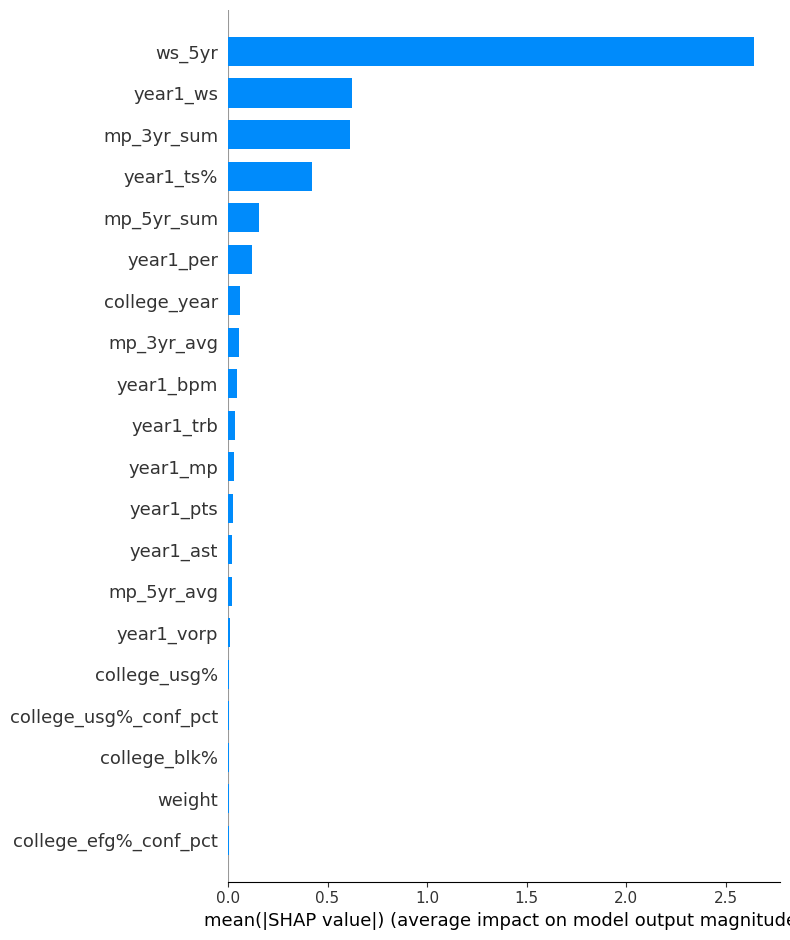

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


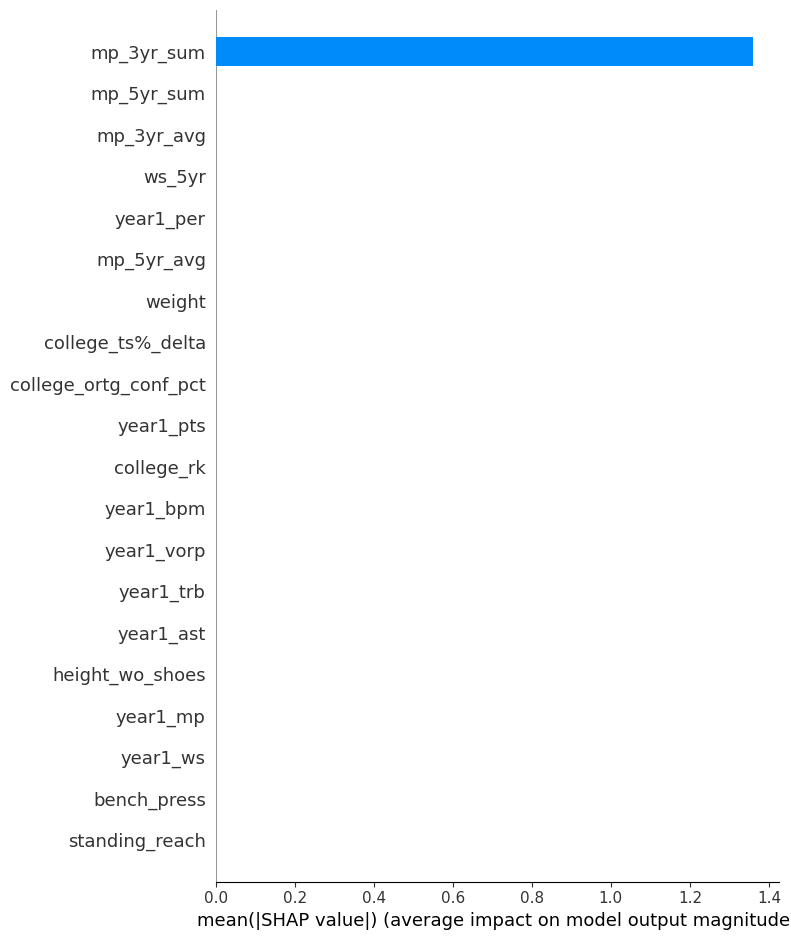

In [105]:
import shap
# Regression model shap
explainer = shap.TreeExplainer(model_reg)
sample = X_hold_num.sample(min(1000, len(X_hold_num)), random_state=42)
shap_vals = explainer.shap_values(sample)
shap.summary_plot(shap_vals, sample, plot_type='bar')

# For classification (rotation)
explainer_clf = shap.TreeExplainer(clf.booster_)
sample_clf = X_hold_num.sample(min(1000, len(X_hold_num)), random_state=42)
shap_vals_clf = explainer_clf.shap_values(sample_clf)
shap.summary_plot(shap_vals_clf, sample_clf, plot_type='bar')


**Embedding visualization & nearest neighbors (UMAP + kNN)**

If you trained an autoencoder embedding, use UMAP to visualize and kNN to get comps. This is useful for scout-style nearest neighbors.

In [106]:
!pip install umap-learn -q
import umap
from sklearn.neighbors import NearestNeighbors

# assume `emb_cols` in stage3 (e.g., embed_0 ... embed_31)
emb_cols = [c for c in stage3.columns if c.startswith('embed_')]
if len(emb_cols)==0:
    print("No embeddings found. Skip UMAP/NN.")
else:
    emb_data = stage3[emb_cols].fillna(0).values
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    emb_2d = reducer.fit_transform(emb_data)
    stage3['emb_x'] = emb_2d[:,0]; stage3['emb_y'] = emb_2d[:,1]

    # plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,6))
    plt.scatter(stage3['emb_x'], stage3['emb_y'], s=6, alpha=0.7)
    plt.title("Player embeddings UMAP")
    plt.show()

    # nearest neighbours
    nn = NearestNeighbors(n_neighbors=6).fit(emb_data)
    def player_neighbors(player_name):
        if player_name not in stage3['player'].values:
            return []
        i = stage3.index[stage3['player']==player_name][0]
        dists, idxs = nn.kneighbors([emb_data[i]])
        neighbors = stage3.iloc[idxs[0]].player.values.tolist()
        return neighbors

    # example
    print(player_neighbors(stage3['player'].iloc[10]))


No embeddings found. Skip UMAP/NN.


In [107]:
joblib.dump(model_reg, "stage3_model_reg_ws3yr.pkl")
joblib.dump(clf, "stage3_model_clf_rotation.pkl")
joblib.dump(FEATS, "stage3_feature_list.pkl")
stage3.to_csv("stage3_dataset.csv", index=False)


**Evaluation report & precision@k for scouts**

For classification tasks (e.g., predicting rotation), scouts often want top-k precision. For regression (ws_3yr) you can rank predictions and check mean observed WS among top k.

In [108]:
# ranking for ws
hold_df = hold_df.reset_index(drop=True)
hold_df['pred_ws3yr'] = y_pred_hold  # from model_reg
hold_df = hold_df.sort_values('pred_ws3yr', ascending=False).reset_index(drop=True)

for k in [10,25,50]:
    true_mean = hold_df.head(k)['ws_3yr'].mean()
    print(f"Mean actual WS (top {k} predicted): {true_mean:.3f}")

# classification top-k precision
hold_df['pred_rotation_proba'] = y_proba
for k in [10,25,50]:
    prec_k = precision_at_k(hold_df['rotation_3yr'].values, hold_df['pred_rotation_proba'].values, k)
    print(f"Rotation Precision@{k}: {prec_k:.3f}")


Mean actual WS (top 10 predicted): 7.780
Mean actual WS (top 25 predicted): 4.900
Mean actual WS (top 50 predicted): 2.992
Rotation Precision@10: 0.700
Rotation Precision@25: 0.680
Rotation Precision@50: 0.420


# Part 7: Conclusion

First, we merge mo's career avg with ethan's career avg and get advanced metrics.

Then that with bennett's career averages.

Second, look at those players and compare to mo's draft dataframe and compare player's advanced stats and average those stats and look at players with above average stats and compare to their draft number.

Then, compare the same player's college numbers to the draft.

Draft to NBA and compare which types of players are getting any awards, top 3. and look at advanced metrics which players have in common

And merge combine data and draft data but before we compare draft nba and draft to college.

For draft dataset, we have ranking of draft and we can average stats by pick number. so we can have average stats by draft pick. with advanced metrics. and also for undrafted guys. and compare that to college stats and nba stats.

and now we are looking for certain stats that stand out between players who go from college to draft to nba and have certain metrics that line up together. more than one stat